In [1]:
%matplotlib inline
import platform
print(platform.python_version())
from ROOT import TFile,vector
import ROOT

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import math


import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from scipy.interpolate import interp1d
from scipy.integrate import quad
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import copy

import seaborn as sns

3.5.2
Welcome to JupyROOT 6.14/08


In [2]:
# davios functions for plotting...
  
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from scipy.interpolate import interp1d
from scipy.integrate import quad
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import copy

def Tune1(df):
    return df['xsec_tune1_weight'].values

def CV(df):
    wgt = df['xsec_corr_weight'].values
    if False:
#     if 'new_weight' in df.columns:
        tmpweights1 = df['new_weight'].values

    else:
        tmpweights1 = []
        for i in range(len(wgt)):
            tmpweights1.append(1.0)
    
    if False:
        tmpweights2 = df['pot_weight'].values
    else:
        tmpweights2 = []
        for i in range(len(wgt)):
            tmpweights2.append(1.0)
            
    for i in range(len(wgt)):
        wgt[i] = wgt[i]*tmpweights1[i]*tmpweights2[i]
        
    wgt[wgt == np.inf] = 1
    wgt = np.nan_to_num(wgt)
    wgt[wgt <= 0] = 1
    
    return wgt

def Spline(df):
    wgt = df['spline_weight'].values
    wgt[wgt == np.inf] = 1
    wgt = np.nan_to_num(wgt)
    wgt[wgt <= 0] = 1
    return wgt


class sampHist:

    def __init__(self,samp_df,samp_l,samp_c,samp_wind,samp_s):
        self._df = samp_df.copy()
        self._label = samp_l
        self._color = samp_c
        self._scale = samp_s
        self._wi = samp_wind
        if samp_wind == 0:
            self._wgt = np.ones(len(samp_df))
        if samp_wind == 1:
            self._wgt = CV(samp_df)

    def setweight(self,windex):
        if windex == 0:
            self._wgt = np.ones(len(self._df))
        if windex == 1:
            self._wgt = CV(self._df)

    def dist(self,s_var):
        return self._df[s_var].values

    def cosdist(self,s_var):
        return np.cos(self._df[s_var].values)

    def applycut(self,s_cut):
        newhist = copy.deepcopy(self)
        newhist._df = self._df.query(s_cut)
        newhist.setweight(self._wi)
        return newhist

class SimpleHisto:

    def __init__ (self,df_df,f_scale,i_wgt,s_color,s_label):
        temp_df = df_df.copy()
        temp_df['myscale'] = f_scale
        self.mydf = temp_df
        self.mycolor = s_color
        self.mylabel = s_label
        self.iwgt = i_wgt

        self.mycut = 'Enu_1m1p > 0'

    def AddCut(self,s_cut):
        self.mycut  = s_cut

    def ClearCut(self):
        self.mycut = 'Enu_1m1p > 0'

    def GetHist(self,s_varname):
        temp_df = self.mydf.query(self.mycut)
        if self.iwgt == 1:
            myweight = CV(temp_df)
        elif self.iwgt == 0:
            myweight = np.ones(len(temp_df))
        return temp_df[s_varname].values,myweight,temp_df['myscale'].values,self.mycolor,self.mylabel

def GetErrorsData(xobs,CL=0.6827):
    step    = 0.01
    upperBoundary = int(max(10,xobs+5*np.sqrt(xobs)))
    r = np.arange(0.01,upperBoundary,step)
    s    = PmuGivenX(r,xobs)*step
    PDF1 = interp1d(r,s,bounds_error=False,fill_value=0)
    PPF1 = interp1d(np.cumsum(s),r)
    xobs_low  = float(PPF1((1-CL)/2))
    xobs_high = float(PPF1(1-(1-CL)/2))
    return xobs_low,xobs_high

class StackedHisto:

    def  __init__ (self,a_df_mc,a_df_scale):
        self.mystrata = []
        self.stratalabel = []
        self.stratacolor = []
        self.mylayer = []
        self.layerlabel = []
        self.layercolor = []
        self.layeriwgt = []
        self.stratxweight = []

        temp_a_df = []
        for i in range(len(a_df_mc)):
            temp_df = a_df_mc[i].copy()
            temp_df['myscale'] = a_df_scale[i]
            temp_a_df.append(temp_df)
        self.mymc = pd.concat(temp_a_df)
        self.mycut ='_pi0mass >0'


    def ClearCut(self):
        self.mycut = 'Enu_1m1p > 0'

    def AddCut(self,s_cut):
        self.mycut  = s_cut

    def AddLayer(self,df_layer,df_scale,i_wgt,s_label,s_color):
        temp_df = df_layer.copy()
        temp_df['myscale'] = df_scale
        self.mylayer.append(temp_df)
        self.layerlabel.append(s_label)
        self.layercolor.append(s_color)
        self.layeriwgt.append(i_wgt)

    def AddStrata(self,s_strata,s_label,s_color,f_wgt=1.0):
        self.mystrata.append(s_strata)
        self.stratalabel.append(s_label)
        self.stratacolor.append(s_color)
        self.stratxweight.append(f_wgt)

    def GetHists(self,s_varname):
        a_vals = []        # (nxN)
        a_wgts = []
        a_scale = []
        a_cols = []        # (nx1)
        a_labels = []

        # first, run  through strata
        for i in range(len(self.mystrata)):
            # isolate this stratum with current cut
            temp_df = self.mymc.query(self.mystrata[i]+' and '+self.mycut)

            a_vals.append(temp_df[s_varname].values)
            a_wgts.append(CV(temp_df) * self.stratxweight[i])   # ah, this is if we want to scale an individual stratum
            a_scale.append(temp_df['myscale'].values)

            a_cols.append(self.stratacolor[i])
            a_labels.append(self.stratalabel[i])

        for i in range(len(self.mylayer)):
            temp_df = self.mylayer[i].query(self.mycut)

            a_vals.append(temp_df[s_varname].values)
            if self.layeriwgt[i] == 1:
                a_wgts.append(CV(temp_df))
            elif self.layeriwgt[i] == 0:
                a_wgts.append(np.ones(len(temp_df)))
            a_scale.append(temp_df['myscale'].values)

            a_cols.append(self.layercolor[i])
            a_labels.append(self.layerlabel[i])

        return  np.asarray(a_vals),np.asarray(a_wgts),np.asarray(a_scale),a_cols,a_labels

    def ClearLayers(self):
        self.mylayer = []
        self.layerlabel = []
        self.layercolor = []
        self.layerwgt = []

    def ClearStrata(self):
        self.mystrata = []
        self.stratalabel = []
        self.stratacolor = []


class distVar:

    def __init__(self,s_name,n_range,s_label='',s_cov=''):
        self.myname = s_name
        self.myrange = n_range
        self.myscov = s_cov
        if s_label == '':
            self.mylabel = s_name
        else:
            self.mylabel = s_label
            
def PmuGivenX(mu,x):

    # Returns the probability density value that the true mean is mu given that you
    # have observed x events. Actually employs a series approximation because the real formula
    # involves a very very large numerator and denominator and overflows even high precision
    # variables if your bins contain more than a few hundred events
    # Approximation is good to O(0.1%) or better at all values

    pi  = np.pi
    c   = [1.,-1./12,1./288,139./51840,-571./2488320,-163879./209018880]

    if x == 0:
        return np.exp(-mu)
    else:
        poly = sum(c[i]/x**(i+0.5) for i in range(len(c)))
        return 1/np.sqrt(2*pi)*np.exp(x+x*np.log(mu/x)-mu)*poly


def distplot_wratio_davio(myvar,nbins,myrange,stackedhists,datahist,stxcoord,m_cov,legpos=0,ymax=-1,normshift=1,fs=(16,11),consFac=0.0):

    #consFac is new and consolidates all MC strata whose contribution is less than a given percent threshold.
    # (my legend was too full of useless stuff)

    vals_mc = np.zeros(nbins)
    vals_mc_raw = np.zeros(nbins)
    yerrsq_mc = np.zeros(nbins)
    yrr_mc_sys = np.zeros(nbins)
    ndof = 0

    a_labels_evts_draw = []
    a_labels_evts_failThresh = []
    a_cols_draw = []
    a_vals_draw = []
    a_wgts_draw = []
    a_vals_failThresh = []
    a_wgts_failThresh = []
    evts_failThresh = 0.0

    gh_vals,gh_wgts,gh_scale,gh_cols,gh_labels = stackedhists.GetHists(myvar)
    data_vals,data_wgt,data_scale,_,data_label = datahist.GetHist(myvar)
    print("hstack gh_weights",np.hstack(gh_wgts))
    print("hstack gh_scale",np.hstack(gh_scale))
    vals_mc_total,binedges = np.histogram(np.hstack(gh_vals),nbins,range=myrange,weights=np.hstack(gh_wgts)*np.hstack(gh_scale))
    mctot = vals_mc_total.sum()
    mcthresh = consFac * mctot


    for i in range(len(gh_vals)):
        h1_raw,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i])     # hist of raw event weights
        h1,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i]*gh_scale[i])

        vals_mc_raw += h1_raw
        vals_mc += h1

        scalesort = gh_scale[i].argsort()
        sorted_vals = gh_vals[i][scalesort[::-1]]
        sorted_scale = gh_scale[i][scalesort[::-1]]
        sorted_wgt = gh_wgts[i][scalesort[::-1]]
        for sc in np.unique(sorted_scale):
            subvals = sorted_vals[sorted_scale==sc]
            subwgts = sorted_wgt[sorted_scale==sc]
            subh1,_ = np.histogram(subvals,nbins,range=myrange,weights=subwgts)
            yerrsq_mc += np.power(np.sqrt(subh1)*sc,2)
       
        a_vals_draw.append(gh_vals[i].copy())
        a_wgts_draw.append((gh_wgts[i]*gh_scale[i]).copy())
        a_labels_evts_draw.append(gh_labels[i]+' (%.2f)'%h1.sum())
        a_cols_draw.append(gh_cols[i])


    vals_data_raw,_ = np.histogram(data_vals,nbins,range=myrange,weights=data_wgt)
    vals_data,_ = np.histogram(data_vals,nbins,range=myrange,weights=np.multiply(data_wgt,data_scale))
    bincenters = np.diff(binedges)/2 + binedges[:-1]

    #jarretbars
    a_obslo = []
    a_obshi = []
    for i in range(nbins):
        obslo,obshi = GetErrorsData(vals_data[i])
        a_obshi.append(obshi-vals_data[i])
        a_obslo.append(vals_data[i]-obslo)

    #m_cov is fractional, so we multiply it by MC
    for i in range(nbins):
        for j in range(nbins):
            if(vals_mc[i] > 0 and vals_mc[j] > 0):
                m_cov[i][j] *= vals_mc[i]*vals_mc[j]
#             else if math.isnan(vals_mc[i]) or math.isnan(vals_mc[j]):
#                 m_cov[i][j] = 0
            else:
                m_cov[i][j] = 0
#             else:
#                 print("uh oh!",vals_mc[i],vals_mc[j] )

    # Normalization uncertainty:
    for i in range(len(m_cov)):
        for j in range(len(m_cov[i])):
            if math.isnan(m_cov[i][j]):
                m_cov[i][j]=0.0000000001
                
    fNorm_squared = m_cov.sum() / np.power(vals_mc.sum(),2)
#     print("first", m_cov)
    print('Normalization Uncertainty:',np.sqrt(fNorm_squared))

    yerr_mc_sys = np.sqrt(np.diag(m_cov))
    yerr_mc_total = np.sqrt(np.diag(m_cov) + yerrsq_mc)

    yerrsq_data = np.zeros(nbins)
    for i in range(nbins):
        if vals_mc_raw[i] > 0:
            ndof += 1
            if vals_data[i] > 0:
                yerrsq_data[i] += (3.0*vals_data[i]*vals_mc[i]*normshift)/(vals_mc[i]*normshift+2.0*vals_data[i])
            else:
                yerrsq_data[i] += vals_mc[i]*normshift/2.0
            m_cov[i][i] += yerrsq_data[i] + yerrsq_mc[i]
        else:
            m_cov[i][i] += 999

    yerr_data = np.sqrt(yerrsq_data)

    er_rat_line = np.zeros(nbins)
    er_rat_line_sys = np.zeros(nbins)
    er_rat_dotshi = np.zeros(nbins)
    er_rat_dotslo = np.zeros(nbins)

    for i in range(nbins):
        if vals_mc[i] > 0:
            er_rat_line[i] = yerr_mc_total[i]/float(vals_mc[i])
            er_rat_line_sys[i] = yerr_mc_sys[i]/float(vals_mc[i])
            er_rat_dotshi[i] = a_obshi[i]/float(vals_mc[i])
            er_rat_dotslo[i] = a_obslo[i]/float(vals_mc[i])

    chisq = 0.0
    invcov = np.linalg.inv(m_cov)

    # calc chi2
    for i in range(nbins):
        for j in range(nbins):
            if vals_mc_raw[i] > 0 and vals_mc_raw[j] > 0 and vals_data[i]>0 and vals_data[j] >0 :
                chisq += (vals_mc[i] - vals_data[i]) * (vals_mc[j] - vals_data[j]) * invcov[i][j]
    pval = 1 - stats.chi2.cdf(chisq, ndof)
    print(chisq/float(ndof),pval)

    fig,ax = plt.subplots(figsize=fs)
    fig.patch.set_alpha(1)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ymax = max((vals_data+np.asarray(a_obshi)).max(),(vals_mc+yerr_mc_sys).max())*1.4

    ax0.set_ylim(0,ymax)
    ax0.set_xlim(myrange)
    ax1.set_ylim(0,2)
    ax1.set_xlim(myrange)
    ax1.set_xlabel(stxcoord,fontsize=20)
    ax0.set_ylabel('Event Count',fontsize=25)
    ax1.set_ylabel('Data/MC',fontsize=25)
    ax0.set_title('MCC9 Data/MC',fontsize=30)

    ax0.hist(a_vals_draw,nbins,range=myrange,weights=a_wgts_draw,color=a_cols_draw,stacked=True,linewidth=0,label=a_labels_evts_draw,edgecolor=None)
    ax0.hist(np.hstack(a_vals_draw),nbins,range=myrange,weights=np.hstack(a_wgts_draw),histtype='step',zorder=20,color='black',linewidth=2)

    ax0.errorbar(bincenters,vals_data,fmt='o',yerr=(a_obslo,a_obshi),color='black',capsize=5,label=data_label+' (%i)'%vals_data.sum(),markersize=8,zorder=20,elinewidth=2)
    ax0.errorbar(bincenters,vals_data,fmt='o',color='white',zorder=19,markersize=16)

    errboxes_tot = []
    errboxes_sys = []

    for i in range(len(bincenters)):
        rect0 = Rectangle((binedges[i],(vals_mc[i]-yerr_mc_sys[i])),binedges[i+1]-binedges[i],yerr_mc_sys[i]*2)
        errboxes_sys.append(rect0)
        rect1 = Rectangle((binedges[i],(vals_mc[i]-yerr_mc_total[i])),binedges[i+1]-binedges[i],yerr_mc_total[i]*2)
        errboxes_tot.append(rect1)
    pc_sys = PatchCollection(errboxes_tot,facecolor='red', alpha=.3,hatch='X',edgecolor='white')
    pc_sys_outline = PatchCollection(errboxes_tot,facecolor='none', alpha=.9,hatch='X',edgecolor='white',zorder=11)
    pc_tot = PatchCollection(errboxes_sys,facecolor=None,alpha=.1,hatch='/',zorder=12)
    ax0.add_collection(pc_sys)
    ax0.add_collection(pc_sys_outline)
    ax0.add_collection(pc_tot)
    ax0.hist(np.zeros(1),(1,2),facecolor=None,alpha=.1,hatch='//',zorder=0,label='MC Systematic Error')
    ax0.hist(np.zeros(1),(1,2),facecolor='red', alpha=.3,hatch='X',edgecolor='white',label='MC Sys+Stat Error')
    ax0.legend(loc='upper right',fontsize=15,frameon=False,ncol=2)

    errboxes_rat_tot = []
    errboxes_rat_sys = []
    for i in range(len(er_rat_dotshi)):
        rect0 = Rectangle((binedges[i],1-er_rat_line[i]),binedges[i+1]-binedges[i],er_rat_line[i]*2)
        errboxes_rat_tot.append(rect0)
        rect1 = Rectangle((binedges[i],1-er_rat_line_sys[i]),binedges[i+1]-binedges[i],er_rat_line_sys[i]*2)
        errboxes_rat_sys.append(rect1)

    pc_rat_tot = PatchCollection(errboxes_rat_tot, facecolor='red', alpha=.3)
    pc_rat_sys = PatchCollection(errboxes_rat_sys, facecolor=None, alpha=.1,hatch='/',zorder=12)
    ax1.add_collection(pc_rat_tot)
    ax1.add_collection(pc_rat_sys)
    ax1.hist(np.zeros(1),(1,2),facecolor=None,alpha=.1,hatch='//',zorder=0)

    ax1.hist(np.zeros(1),(1,2),facecolor='red',alpha=.3,zorder=0)
    ax1.errorbar(bincenters,np.true_divide(vals_data,vals_mc),yerr=(er_rat_dotshi,er_rat_dotslo),fmt='o',color='maroon',capsize=0,markersize=8,elinewidth=2)

    #ax1.legend(loc='lower right',fontsize=15,frameon=False)

    ax1.axhline(1,color='black',linestyle=':')
    ax0.annotate(r'$\sum$data/$\sum$MC = %.2f $\pm$ %.2f'%(vals_data.sum()/float(vals_mc.sum()),np.sqrt(fNorm_squared)),xy=(.01,.92),xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))

    ax1.annotate('p-value: %.3f\n'%pval+r'$\chi^2_{CNP}/%i  (dof)$: %.3f'%(ndof,chisq/float(ndof)),xy=(.85,.7), xycoords='axes fraction',fontsize=15,bbox=dict(boxstyle="round4", fc="w",alpha=.9),zorder=30)

    plt.tight_layout()

    return fig,ax0,ax1,pval

def distplot_mc(myvar,nbins,myrange,stackedhists,stxcoord,legpos=0,ymax=-1,normshift=1,fs=(16,11),consFac=0.0):

    #for plotting truth variables

    vals_mc = np.zeros(nbins)
    vals_mc_raw = np.zeros(nbins)
    yerrsq_mc = np.zeros(nbins)
    yrr_mc_sys = np.zeros(nbins)
    ndof = 0

    a_labels_evts_draw = []
    a_labels_evts_failThresh = []
    a_cols_draw = []
    a_vals_draw = []
    a_wgts_draw = []
    a_vals_failThresh = []
    a_wgts_failThresh = []
    evts_failThresh = 0.0

    gh_vals,gh_wgts,gh_scale,gh_cols,gh_labels = stackedhists.GetHists(myvar)
    print("hstack gh_weights",np.hstack(gh_wgts))
    print("hstack gh_scale",np.hstack(gh_scale))
    vals_mc_total,binedges = np.histogram(np.hstack(gh_vals),nbins,range=myrange,weights=np.hstack(gh_wgts)*np.hstack(gh_scale))
    mctot = vals_mc_total.sum()
    mcthresh = consFac * mctot


    for i in range(len(gh_vals)):
        h1_raw,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i])     # hist of raw event weights
        h1,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i]*gh_scale[i])

        vals_mc_raw += h1_raw
        vals_mc += h1

        scalesort = gh_scale[i].argsort()
        sorted_vals = gh_vals[i][scalesort[::-1]]
        sorted_scale = gh_scale[i][scalesort[::-1]]
        sorted_wgt = gh_wgts[i][scalesort[::-1]]
        for sc in np.unique(sorted_scale):
            subvals = sorted_vals[sorted_scale==sc]
            subwgts = sorted_wgt[sorted_scale==sc]
            subh1,_ = np.histogram(subvals,nbins,range=myrange,weights=subwgts)
            yerrsq_mc += np.power(np.sqrt(subh1)*sc,2)
       
        a_vals_draw.append(gh_vals[i].copy())
        a_wgts_draw.append((gh_wgts[i]*gh_scale[i]).copy())
        a_labels_evts_draw.append(gh_labels[i]+' (%.2f)'%h1.sum())
        a_cols_draw.append(gh_cols[i])


   
  

   

    fig,ax = plt.subplots(figsize=fs)

    ymax = (vals_mc).max()*1.4

    ax.set_ylim(0,ymax)
    ax.set_xlim(myrange)
    ax.set_xlabel(stxcoord,fontsize=20)
    ax.set_ylabel('Event Count',fontsize=25)
    ax.set_title('MCC9 MC',fontsize=30)

    ax.hist(a_vals_draw,nbins,range=myrange,weights=a_wgts_draw,color=a_cols_draw,stacked=True,linewidth=0,label=a_labels_evts_draw,edgecolor=None)
    ax.hist(np.hstack(a_vals_draw),nbins,range=myrange,weights=np.hstack(a_wgts_draw),histtype='step',zorder=20,color='black',linewidth=2)

    ax.legend(loc='upper right',fontsize=15,frameon=False,ncol=2)

    
    plt.tight_layout()

    return fig,ax

In [14]:
NUMU_R1_POT = 1.33678E+21
NUE_R1_POT  = 9.80259e+22

NUMU_R3_POT = 8.98773223801e+20
NUE_R3_POT = 4.707047e+22

CCPI0_R1_POT = 6.95344e+20
CCPI0_R3_POT = 5.92213e+20
NCPI0_R1_POT = 2.90401e+21
NCPI0_R3a_POT = 2.62745e+20
NCPI0_R3b_POT = 2.22482e+21
NCPI0_R3_POT=NCPI0_R3a_POT+NCPI0_R3b_POT


FAKE_DATA_1_RUN1_POT = 1.94e20
FAKE_DATA_1_RUN3_POT = 3.00e20

FAKE_DATA_2_RUN1_POT = 4.01e+20
FAKE_DATA_2_RUN3_POT = 3.85e+20

FAKE_DATA_3_RUN1_POT = 4.02e+20
FAKE_DATA_3_RUN3_POT = 3.97e+20

FAKE_DATA_4_RUN1_POT = 3.91e+20
FAKE_DATA_4_RUN3_POT = 3.92e+20

FAKE_DATA_5_RUN1_POT = 7.01e+20

FAKE_DATA_7_RUN1_POT = 1.84e+20
FAKE_DATA_7_RUN3_POT = 2.05e+20

POT_SCALE_FACTOR = 1.0 #if I feel like playing with scaling
# CURRENT TOTAL
DATA_POT_TOTAL_1 = FAKE_DATA_1_RUN1_POT+FAKE_DATA_1_RUN3_POT
DATA_POT_TOTAL_2 = FAKE_DATA_2_RUN1_POT+FAKE_DATA_2_RUN3_POT
DATA_POT_TOTAL_3 = FAKE_DATA_3_RUN1_POT+FAKE_DATA_3_RUN3_POT
DATA_POT_TOTAL_4 = FAKE_DATA_4_RUN1_POT+FAKE_DATA_4_RUN3_POT
DATA_POT_TOTAL_5 = FAKE_DATA_5_RUN1_POT
DATA_POT_TOTAL_7 = FAKE_DATA_7_RUN1_POT+FAKE_DATA_7_RUN3_POT
print("total POT: ",DATA_POT_TOTAL_1,DATA_POT_TOTAL_2,DATA_POT_TOTAL_3,DATA_POT_TOTAL_4,DATA_POT_TOTAL_5,DATA_POT_TOTAL_7)

total POT:  4.94e+20 7.86e+20 7.99e+20 7.83e+20 7.01e+20 3.89e+20


In [5]:
NUMU_R1_FAKE1_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_1_RUN1_POT)/ float(NUMU_R1_POT)
NUE_R1_FAKE1_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_1_RUN1_POT)/ float(NUE_R1_POT)
NUMU_R1_FAKE2_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_2_RUN1_POT)/ float(NUMU_R1_POT)
NUE_R1_FAKE2_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_2_RUN1_POT)/ float(NUE_R1_POT)
NUMU_R1_FAKE3_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_3_RUN1_POT)/ float(NUMU_R1_POT)
NUE_R1_FAKE3_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_3_RUN1_POT)/ float(NUE_R1_POT)
NUMU_R1_FAKE4_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_4_RUN1_POT)/ float(NUMU_R1_POT)
NUE_R1_FAKE4_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_4_RUN1_POT)/ float(NUE_R1_POT)
NUMU_R1_FAKE5_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_5_RUN1_POT)/ float(NUMU_R1_POT)
NUE_R1_FAKE5_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_5_RUN1_POT)/ float(NUE_R1_POT)
NUMU_R1_FAKE7_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_7_RUN1_POT)/ float(NUMU_R1_POT)
NUE_R1_FAKE7_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_7_RUN1_POT)/ float(NUE_R1_POT)


NUMU_R3_FAKE1_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_1_RUN3_POT)/ float(NUMU_R3_POT)
NUE_R3_FAKE1_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_1_RUN3_POT)/ float(NUE_R3_POT)
NUMU_R3_FAKE2_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_2_RUN3_POT)/ float(NUMU_R3_POT)
NUE_R3_FAKE2_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_2_RUN3_POT)/ float(NUE_R3_POT)
NUMU_R3_FAKE3_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_3_RUN3_POT)/ float(NUMU_R3_POT)
NUE_R3_FAKE3_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_3_RUN3_POT)/ float(NUE_R3_POT)
NUMU_R3_FAKE4_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_4_RUN3_POT)/ float(NUMU_R3_POT)
NUE_R3_FAKE4_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_4_RUN3_POT)/ float(NUE_R3_POT)
NUMU_R3_FAKE7_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_7_RUN3_POT)/ float(NUMU_R3_POT)
NUE_R3_FAKE7_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_7_RUN3_POT)/ float(NUE_R3_POT)

CCPI0_R1_FAKE1_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_1_RUN1_POT)/ float(CCPI0_R1_POT)
CCPI0_R1_FAKE2_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_2_RUN1_POT)/ float(CCPI0_R1_POT)
CCPI0_R1_FAKE3_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_3_RUN1_POT)/ float(CCPI0_R1_POT)
CCPI0_R1_FAKE4_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_4_RUN1_POT)/ float(CCPI0_R1_POT)
CCPI0_R1_FAKE5_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_5_RUN1_POT)/ float(CCPI0_R1_POT)
CCPI0_R1_FAKE7_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_7_RUN1_POT)/ float(CCPI0_R1_POT)

CCPI0_R3_FAKE1_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_1_RUN3_POT)/ float(CCPI0_R3_POT)
CCPI0_R3_FAKE2_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_2_RUN3_POT)/ float(CCPI0_R3_POT)
CCPI0_R3_FAKE3_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_3_RUN3_POT)/ float(CCPI0_R3_POT)
CCPI0_R3_FAKE4_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_4_RUN3_POT)/ float(CCPI0_R3_POT)
CCPI0_R3_FAKE7_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_7_RUN3_POT)/ float(CCPI0_R3_POT)

NCPI0_R1_FAKE1_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_1_RUN1_POT)/ float(NCPI0_R1_POT)
NCPI0_R1_FAKE2_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_2_RUN1_POT)/ float(NCPI0_R1_POT)
NCPI0_R1_FAKE3_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_3_RUN1_POT)/ float(NCPI0_R1_POT)
NCPI0_R1_FAKE4_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_4_RUN1_POT)/ float(NCPI0_R1_POT)
NCPI0_R1_FAKE5_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_5_RUN1_POT)/ float(NCPI0_R1_POT)
NCPI0_R1_FAKE7_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_7_RUN1_POT)/ float(NCPI0_R1_POT)

NCPI0_R3_FAKE1_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_1_RUN3_POT)/ float(NCPI0_R3_POT)
NCPI0_R3_FAKE2_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_2_RUN3_POT)/ float(NCPI0_R3_POT)
NCPI0_R3_FAKE3_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_3_RUN3_POT)/ float(NCPI0_R3_POT)
NCPI0_R3_FAKE4_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_4_RUN3_POT)/ float(NCPI0_R3_POT)
NCPI0_R3_FAKE7_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_7_RUN3_POT)/ float(NCPI0_R3_POT)

In [6]:
# Or, we can load from pickles if you, you know, want to.
# Pickle read for easy access later, eh?
tag = 'Feb_4_run1_numu_v1'
df_numu_goodruns_pmtprecut = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_6_run1_nue_v1'
df_nue_goodruns_pmtprecut = pd.read_pickle('../data/pickles/nue_goodruns_precuts_%s.pickle'%tag)

tag = 'Nov_6_run3_numu_v1'
df_numu_r3_goodruns_pmtprecut = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_6_run3_nue_v1'
df_nue_r3_goodruns_pmtprecut = pd.read_pickle('../data/pickles/nue_goodruns_precuts_%s.pickle'%tag)

tag = 'Jan_15_run1_CCPi0'
df_ccpi0_r1_goodruns_pmtprecut = pd.read_pickle('../data/pickles/%s.pickle'%tag)
print("all events: ", len(df_ccpi0_r1_goodruns_pmtprecut))
print(" haspi0 events: ", len(df_ccpi0_r1_goodruns_pmtprecut.query("haspi0==1")))
tag = 'Jan_15_run3_CCPi0'
df_ccpi0_r3_goodruns_pmtprecut = pd.read_pickle('../data/pickles/%s.pickle'%tag)
tag = 'Jan_15_run1_NCPi0'
df_ncpi0_r1_goodruns_pmtprecut = pd.read_pickle('../data/pickles/%s.pickle'%tag)
tag = 'Jan_15_run3a_NCPi0'
df_ncpi0_r3a_goodruns_pmtprecut = pd.read_pickle('../data/pickles/%s.pickle'%tag)
tag = 'Jan_15_run3b_NCPi0'
df_ncpi0_r3b_goodruns_pmtprecut = pd.read_pickle('../data/pickles/%s.pickle'%tag)
# combine r3a,r3b files
df_ncpi0_r3_goodruns_pmtprecut = df_ncpi0_r3a_goodruns_pmtprecut.append(df_ncpi0_r3b_goodruns_pmtprecut)

ccpi0r1pi0=np.ones(len(df_ccpi0_r1_goodruns_pmtprecut))
df_ccpi0_r1_goodruns_pmtprecut["newhaspi0"] = ccpi0r1pi0
ccpi0r3pi0=np.ones(len(df_ccpi0_r3_goodruns_pmtprecut))
df_ccpi0_r3_goodruns_pmtprecut["newhaspi0"] = ccpi0r3pi0

ncpi0r1pi0=np.ones(len(df_ncpi0_r1_goodruns_pmtprecut))
df_ncpi0_r1_goodruns_pmtprecut["newhaspi0"] = ncpi0r1pi0
ncpi0r3pi0=np.ones(len(df_ncpi0_r3_goodruns_pmtprecut))
df_ncpi0_r3_goodruns_pmtprecut["newhaspi0"] = ncpi0r3pi0


tag = 'Apr_14_fake1_run3'
df_fakedata1_goodruns_run3_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
tag = 'Apr_14_fake1_run1'
df_fakedata1_goodruns_run1_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)

tag = 'Apr_14_fake2_run3'
df_fakedata2_goodruns_run3_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
tag = 'Apr_14_fake2_run1'
df_fakedata2_goodruns_run1_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)

tag = 'Apr_14_fake3_run3'
df_fakedata3_goodruns_run3_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
tag = 'Apr_14_fake3_run1'
df_fakedata3_goodruns_run1_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)

tag = 'Apr_14_fake4_run3'
df_fakedata4_goodruns_run3_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
tag = 'Apr_14_fake4_run1'
df_fakedata4_goodruns_run1_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)

tag = 'Apr_14_fake5_run1'
df_fakedata5_goodruns_run1_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)

tag = 'Apr_14_fake7_run3'
df_fakedata7_goodruns_run3_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
tag = 'Apr_14_fake7_run1'
df_fakedata7_goodruns_run1_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
print("done")

all events:  3307
 haspi0 events:  3307
done


In [7]:
# cut on new shower variables separately
cuts_new = 'good ==1 and PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1 and _pi0mass_new<400 and DeltaMass_new >0 and DeltaMass_new <1400 and NTracks ==2 and Proton_Edep>60.0  and Electron_Edep>35.0  and shower1_E_Y_new>80 and ChargeNearTrunk >250 and Electron_ThetaRecoB_e1ep <1.5 and _shower_alpha <2.5 and _pi0mass_new>0 and BDTscore_1e1p<.7 '
cuts_2 = 'PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1 and _pi0mass_new<400 and DeltaMass_new >0 and DeltaMass_new <1400 and NTracks ==2 and Proton_Edep>60.0  and Electron_Edep>35.0  and shower1_E_Y_new>80 and ChargeNearTrunk >250 and Electron_ThetaRecoB_e1ep <1.5 and _shower_alpha <2.5 and _pi0mass_new>0 and BDTscore_1e1p<.7'
cuts_fake = 'PassShowerReco ==1 and InFiducial ==1 and _pi0mass_new<400 and DeltaMass_new >0 and DeltaMass_new <1400 and NTracks ==2 and Proton_Edep>60.0  and Electron_Edep>35.0  and shower1_E_Y_new>80 and ChargeNearTrunk >250 and Electron_ThetaRecoB_e1ep <1.5 and _shower_alpha <2.5 and _pi0mass_new>0 and BDTscore_1e1p<.7'

RSE = ['run','subrun','event']
sort = 'shower1_E_Y'

# now apply cuts
df_numu_pi0 = df_numu_goodruns_pmtprecut.query(cuts_new+ 'and not (nu_interaction_ccnc==0 and abs(nu_pdg)==12)')
df_numu_pi0 = df_numu_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
print(df_numu_goodruns_pmtprecut['xsec_corr_weight'].values)
df_nue_pi0 = df_nue_goodruns_pmtprecut.query(cuts_new + ' and not (nu_interaction_ccnc==0 and abs(nu_pdg)==14)')
df_nue_pi0 = df_nue_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()

df_numu_r3_pi0 = df_numu_r3_goodruns_pmtprecut.query(cuts_new+ 'and not (nu_interaction_ccnc==0 and abs(nu_pdg)==12)')
df_numu_r3_pi0 = df_numu_r3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_nue_r3_pi0 = df_nue_r3_goodruns_pmtprecut.query(cuts_new+ 'and not (nu_interaction_ccnc==0 and abs(nu_pdg)==14)')
df_nue_r3_pi0 = df_nue_r3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()

# mc pi0 samples
df_ccpi0_r1_pi0 = df_ccpi0_r1_goodruns_pmtprecut.query(cuts_new)
df_ccpi0_r1_pi0 = df_ccpi0_r1_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ccpi0_r3_pi0 = df_ccpi0_r3_goodruns_pmtprecut.query(cuts_2)
df_ccpi0_r3_pi0 = df_ccpi0_r3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ncpi0_r1_pi0 = df_ncpi0_r1_goodruns_pmtprecut.query(cuts_2)
df_ncpi0_r1_pi0 = df_ncpi0_r1_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ncpi0_r3_pi0 = df_ncpi0_r3_goodruns_pmtprecut.query(cuts_2)
df_ncpi0_r3_pi0 = df_ncpi0_r3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
print("pi0 lengths: ", len(df_ccpi0_r1_pi0), len(df_ccpi0_r3_pi0), len(df_ncpi0_r1_pi0), len(df_ncpi0_r3_pi0))

df_fakedata1_run1_pi0 = df_fakedata1_goodruns_run1_pmtprecut.query(cuts_fake)
df_fakedata1_run1_pi0 = df_fakedata1_run1_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_fakedata1_run3_pi0 = df_fakedata1_goodruns_run3_pmtprecut.query(cuts_fake)
df_fakedata1_run3_pi0 = df_fakedata1_run3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_fakedata2_run1_pi0 = df_fakedata2_goodruns_run1_pmtprecut.query(cuts_fake)
df_fakedata2_run1_pi0 = df_fakedata2_run1_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_fakedata2_run3_pi0 = df_fakedata2_goodruns_run3_pmtprecut.query(cuts_fake)
df_fakedata2_run3_pi0 = df_fakedata2_run3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_fakedata3_run1_pi0 = df_fakedata3_goodruns_run1_pmtprecut.query(cuts_fake)
df_fakedata3_run1_pi0 = df_fakedata3_run1_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_fakedata3_run3_pi0 = df_fakedata3_goodruns_run3_pmtprecut.query(cuts_fake)
df_fakedata3_run3_pi0 = df_fakedata3_run3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_fakedata4_run1_pi0 = df_fakedata4_goodruns_run1_pmtprecut.query(cuts_fake)
df_fakedata4_run1_pi0 = df_fakedata4_run1_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_fakedata4_run3_pi0 = df_fakedata4_goodruns_run3_pmtprecut.query(cuts_fake)
df_fakedata4_run3_pi0 = df_fakedata4_run3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_fakedata5_run1_pi0 = df_fakedata5_goodruns_run1_pmtprecut.query(cuts_fake)
df_fakedata5_run1_pi0 = df_fakedata5_run1_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_fakedata7_run1_pi0 = df_fakedata7_goodruns_run1_pmtprecut.query(cuts_fake)
df_fakedata7_run1_pi0 = df_fakedata7_run1_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_fakedata7_run3_pi0 = df_fakedata7_goodruns_run3_pmtprecut.query(cuts_fake)
df_fakedata7_run3_pi0 = df_fakedata7_run3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()

# make weights
weights_numu_r1_fake1_pi0 = CV(df_numu_pi0)*NUMU_R1_FAKE1_SCALE
weights_nue_r1_fake1_pi0 = CV(df_nue_pi0)*NUE_R1_FAKE1_SCALE
weights_ccpi0_r1_fake1_pi0 = CV(df_ccpi0_r1_pi0)*CCPI0_R1_FAKE1_SCALE
weights_ncpi0_r1_fake1_pi0 = CV(df_ncpi0_r1_pi0)*NCPI0_R1_FAKE1_SCALE

weights_numu_r3_fake1_pi0 = CV(df_numu_r3_pi0)*NUMU_R3_FAKE1_SCALE
weights_nue_r3_fake1_pi0 = CV(df_nue_r3_pi0)*NUE_R3_FAKE1_SCALE
weights_ccpi0_r3_fake1_pi0 = CV(df_ccpi0_r3_pi0)*CCPI0_R3_FAKE1_SCALE
weights_ncpi0_r3_fake1_pi0 = CV(df_ncpi0_r3_pi0)*NCPI0_R3_FAKE1_SCALE

weights_numu_r1_fake2_pi0 = CV(df_numu_pi0)*NUMU_R1_FAKE2_SCALE
weights_nue_r1_fake2_pi0 = CV(df_nue_pi0)*NUE_R1_FAKE2_SCALE
weights_ccpi0_r1_fake2_pi0 = CV(df_ccpi0_r1_pi0)*CCPI0_R1_FAKE2_SCALE
weights_ncpi0_r1_fake2_pi0 = CV(df_ncpi0_r1_pi0)*NCPI0_R1_FAKE2_SCALE

weights_numu_r3_fake2_pi0 = CV(df_numu_r3_pi0)*NUMU_R3_FAKE2_SCALE
weights_nue_r3_fake2_pi0 = CV(df_nue_r3_pi0)*NUE_R3_FAKE2_SCALE
weights_ccpi0_r3_fake2_pi0 = CV(df_ccpi0_r3_pi0)*CCPI0_R3_FAKE2_SCALE
weights_ncpi0_r3_fake2_pi0 = CV(df_ncpi0_r3_pi0)*NCPI0_R3_FAKE2_SCALE

weights_numu_r1_fake3_pi0 = CV(df_numu_pi0)*NUMU_R1_FAKE3_SCALE
weights_nue_r1_fake3_pi0 = CV(df_nue_pi0)*NUE_R1_FAKE3_SCALE
weights_ccpi0_r1_fake3_pi0 = CV(df_ccpi0_r1_pi0)*CCPI0_R1_FAKE3_SCALE
weights_ncpi0_r1_fake3_pi0 = CV(df_ncpi0_r1_pi0)*NCPI0_R1_FAKE3_SCALE

weights_numu_r3_fake3_pi0 = CV(df_numu_r3_pi0)*NUMU_R3_FAKE3_SCALE
weights_nue_r3_fake3_pi0 = CV(df_nue_r3_pi0)*NUE_R3_FAKE3_SCALE
weights_ccpi0_r3_fake3_pi0 = CV(df_ccpi0_r3_pi0)*CCPI0_R3_FAKE3_SCALE
weights_ncpi0_r3_fake3_pi0 = CV(df_ncpi0_r3_pi0)*NCPI0_R3_FAKE3_SCALE

weights_numu_r1_fake4_pi0 = CV(df_numu_pi0)*NUMU_R1_FAKE4_SCALE
weights_nue_r1_fake4_pi0 = CV(df_nue_pi0)*NUE_R1_FAKE4_SCALE
weights_ccpi0_r1_fake4_pi0 = CV(df_ccpi0_r1_pi0)*CCPI0_R1_FAKE4_SCALE
weights_ncpi0_r1_fake4_pi0 = CV(df_ncpi0_r1_pi0)*NCPI0_R1_FAKE4_SCALE

weights_numu_r3_fake4_pi0 = CV(df_numu_r3_pi0)*NUMU_R3_FAKE4_SCALE
weights_nue_r3_fake4_pi0 = CV(df_nue_r3_pi0)*NUE_R3_FAKE4_SCALE
weights_ccpi0_r3_fake4_pi0 = CV(df_ccpi0_r3_pi0)*CCPI0_R3_FAKE4_SCALE
weights_ncpi0_r3_fake4_pi0 = CV(df_ncpi0_r3_pi0)*NCPI0_R3_FAKE4_SCALE

weights_numu_r1_fake5_pi0 = CV(df_numu_pi0)*NUMU_R1_FAKE5_SCALE
weights_nue_r1_fake5_pi0 = CV(df_nue_pi0)*NUE_R1_FAKE5_SCALE
weights_ccpi0_r1_fake5_pi0 = CV(df_ccpi0_r1_pi0)*CCPI0_R1_FAKE5_SCALE
weights_ncpi0_r1_fake5_pi0 = CV(df_ncpi0_r1_pi0)*NCPI0_R1_FAKE5_SCALE

weights_numu_r1_fake7_pi0 = CV(df_numu_pi0)*NUMU_R1_FAKE7_SCALE
weights_nue_r1_fake7_pi0 = CV(df_nue_pi0)*NUE_R1_FAKE7_SCALE
weights_ccpi0_r1_fake7_pi0 = CV(df_ccpi0_r1_pi0)*CCPI0_R1_FAKE7_SCALE
weights_ncpi0_r1_fake7_pi0 = CV(df_ncpi0_r1_pi0)*NCPI0_R1_FAKE7_SCALE

weights_numu_r3_fake7_pi0 = CV(df_numu_r3_pi0)*NUMU_R3_FAKE7_SCALE
weights_nue_r3_fake7_pi0 = CV(df_nue_r3_pi0)*NUE_R3_FAKE7_SCALE
weights_ccpi0_r3_fake7_pi0 = CV(df_ccpi0_r3_pi0)*CCPI0_R3_FAKE7_SCALE
weights_ncpi0_r3_fake7_pi0 = CV(df_ncpi0_r3_pi0)*NCPI0_R3_FAKE7_SCALE

weights_fakedata1_run1_pi0 = np.ones(len(df_fakedata1_run1_pi0))*FAKE_DATA_1_RUN1_POT
weights_fakedata1_run3_pi0 = np.ones(len(df_fakedata1_run3_pi0))*FAKE_DATA_1_RUN3_POT
weights_fakedata2_run1_pi0 = np.ones(len(df_fakedata2_run1_pi0))*FAKE_DATA_2_RUN1_POT
weights_fakedata2_run3_pi0 = np.ones(len(df_fakedata2_run3_pi0))*FAKE_DATA_2_RUN3_POT
weights_fakedata3_run1_pi0 = np.ones(len(df_fakedata3_run1_pi0))*FAKE_DATA_3_RUN1_POT
weights_fakedata3_run3_pi0 = np.ones(len(df_fakedata3_run3_pi0))*FAKE_DATA_3_RUN3_POT
weights_fakedata4_run1_pi0 = np.ones(len(df_fakedata4_run1_pi0))*FAKE_DATA_4_RUN1_POT
weights_fakedata4_run3_pi0 = np.ones(len(df_fakedata4_run3_pi0))*FAKE_DATA_4_RUN3_POT
weights_fakedata5_run1_pi0 = np.ones(len(df_fakedata5_run1_pi0))*FAKE_DATA_5_RUN1_POT
weights_fakedata7_run1_pi0 = np.ones(len(df_fakedata7_run1_pi0))*FAKE_DATA_7_RUN1_POT
weights_fakedata7_run3_pi0 = np.ones(len(df_fakedata7_run3_pi0))*FAKE_DATA_7_RUN3_POT


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
cols = df_numu_pi0.columns.tolist()
print(cols)

[1. 1. 1. ... 1. 1. 1.]
pi0 lengths:  1121 1011 1134 1174
['mc_label', 'xsec_tune1_weight', 'run', 'subrun', 'event', 'vtxid', 'Xreco', 'Yreco', 'Zreco', 'InFiducial', 'AnyReco', 'NTracks', 'N5cmTracks', 'PassSimpleCuts', 'PassShowerReco', 'PassSecondShower', 'FailedBoost', 'FailedBoost_1m1p', 'FailedBoost_1e1p', 'Good3DReco', 'Eta', 'OpenAng', 'Thetas', 'Phis', 'QCorrectionFactorVertex', 'ChargeNearTrunk', 'LongTrackLen', 'ShortTrackLen', 'MaxShrFrac', 'MinShrFrac', 'CCQEEnergyShift_1m1p', 'Enu_1m1p', 'PhiT_1m1p', 'AlphaT_1m1p', 'PT_1m1p', 'PTRat_1m1p', 'BjX_1m1p', 'BjY_1m1p', 'Q2_1m1p', 'Sph_1m1p', 'PzEnu_1m1p', 'Q0_1m1p', 'Q3_1m1p', 'OpenAngB_1m1p', 'ThetasB_1m1p', 'PhisB_1m1p', 'PhiTB_1m1p', 'AlphaTB_1m1p', 'PTB_1m1p', 'BjXB_1m1p', 'BjYB_1m1p', 'Q2B_1m1p', 'SphB_1m1p', 'CCQEEnergyShift_1e1p', 'Enu_1e1p', 'PhiT_1e1p', 'AlphaT_1e1p', 'PT_1e1p', 'PTRat_1e1p', 'BjX_1e1p', 'BjY_1e1p', 'Q2_1e1p', 'Sph_1e1p', 'PzEnu_1e1p', 'Q0_1e1p', 'Q3_1e1p', 'OpenAngB_1e1p', 'ThetasB_1e1p', 'PhisB_1e1p

In [8]:
# #seperate out truth types
# df_bnb_ncpi0 = df_numu_pi0.query('haspi0==1 and ccnc==1 and MC_scedr<5 ')
# df_bnb_ccpi0 = df_numu_pi0.query("haspi0==1 and ccnc!=1 and MC_scedr<5") 
# df_bnb_pi0_offvtx = df_numu_pi0.query("haspi0==1 and MC_scedr>=5 ") 
# df_bnb_other_offvtx = df_numu_pi0.query("haspi0==0 and MC_scedr>=5 ")
# df_bnb_other_good = df_numu_pi0.query("haspi0==0 and MC_scedr<5")

# df_bnb_ncpi0_r3 = df_numu_r3_pi0.query('haspi0==1 and ccnc==1 and MC_scedr<5 ')
# df_bnb_ccpi0_r3 = df_numu_r3_pi0.query("haspi0==1 and ccnc!=1 and MC_scedr<5") 
# df_bnb_pi0_offvtx_r3 = df_numu_r3_pi0.query("haspi0==1 and MC_scedr>=5 ") 
# df_bnb_other_offvtx_r3 = df_numu_r3_pi0.query("haspi0==0 and MC_scedr>=5 ")
# df_bnb_other_good_r3 = df_numu_r3_pi0.query("haspi0==0 and MC_scedr<5")

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.14512485 0.14512485 0.14512485 ... 0.06680418 0.06680418 0.06680418]
Normalization Uncertainty: 0.0
1.236752786172174 0.21175576444182886


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.33378832 0.33378832 0.33378832 ... 0.12059986 0.12059986 0.12059986]
Normalization Uncertainty: 0.0
0.6646719097651814 0.8644418441317829


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.29997457 0.29997457 0.29997457 ... 0.13808492 0.13808492 0.13808492]
Normalization Uncertainty: 0.0
1.3737285136790107 0.12243246917107542


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.42836167 0.42836167 0.42836167 ... 0.15476983 0.15476983 0.15476983]
Normalization Uncertainty: 0.0
0.9086556986655978 0.576005447671777


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.30072263 0.30072263 0.30072263 ... 0.13842928 0.13842928 0.13842928]
Normalization Uncertainty: 0.0
4.231532946736397 6.338486402412968e-10


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.4417132  0.4417132  0.4417132  ... 0.15959382 0.15959382 0.15959382]
Normalization Uncertainty: 0.0
1.9644801467233357 0.006135617684283168


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.2924939  0.2924939  0.2924939  ... 0.13464141 0.13464141 0.13464141]
Normalization Uncertainty: 0.0
5.028093165346734 9.990896998601784e-13


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.43615007 0.43615007 0.43615007 ... 0.15758382 0.15758382 0.15758382]
Normalization Uncertainty: 0.0
2.6623228561921195 7.475932133860219e-05


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.52439444 0.52439444 0.52439444 ... 0.24139035 0.24139035 0.24139035]
Normalization Uncertainty: 0.0
0.6963858433903838 0.8341418576840447


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.13764419 0.13764419 0.13764419 ... 0.06336066 0.06336066 0.06336066]
Normalization Uncertainty: 0.0
1.3422147294988098 0.1397017626970355


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.22808868 0.22808868 0.22808868 ... 0.08240991 0.08240991 0.08240991]
Normalization Uncertainty: 0.0
1.178975387439062 0.261242607181714


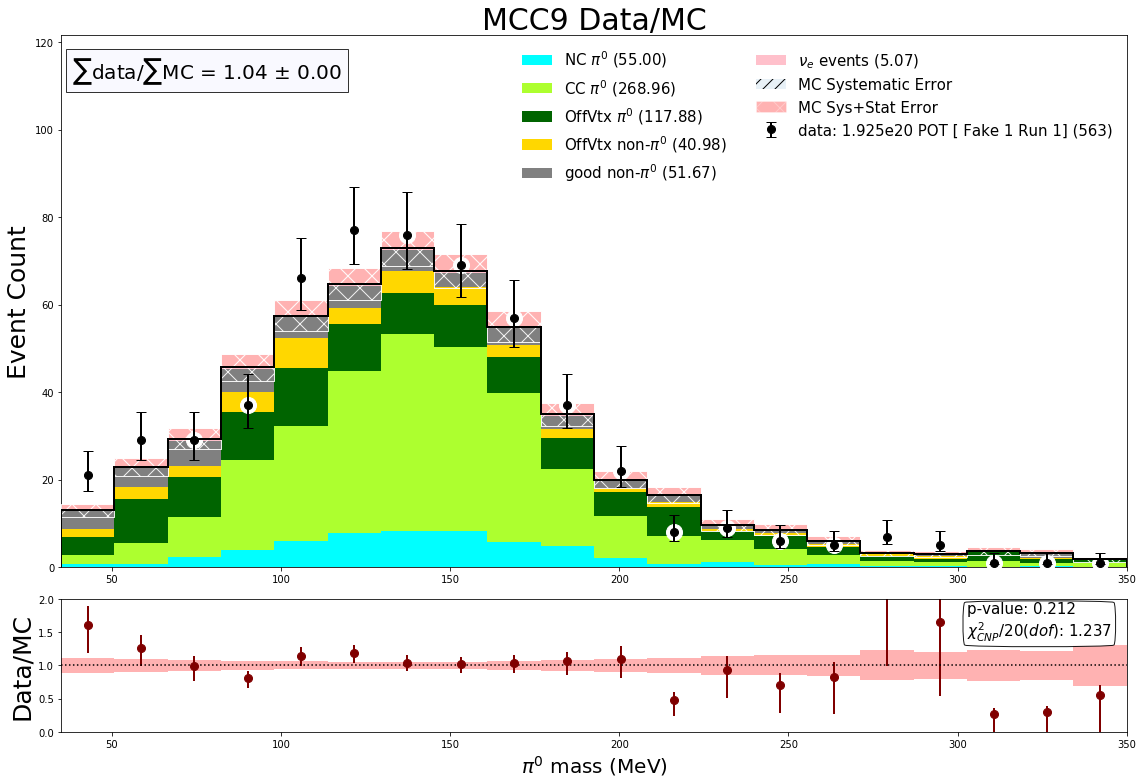

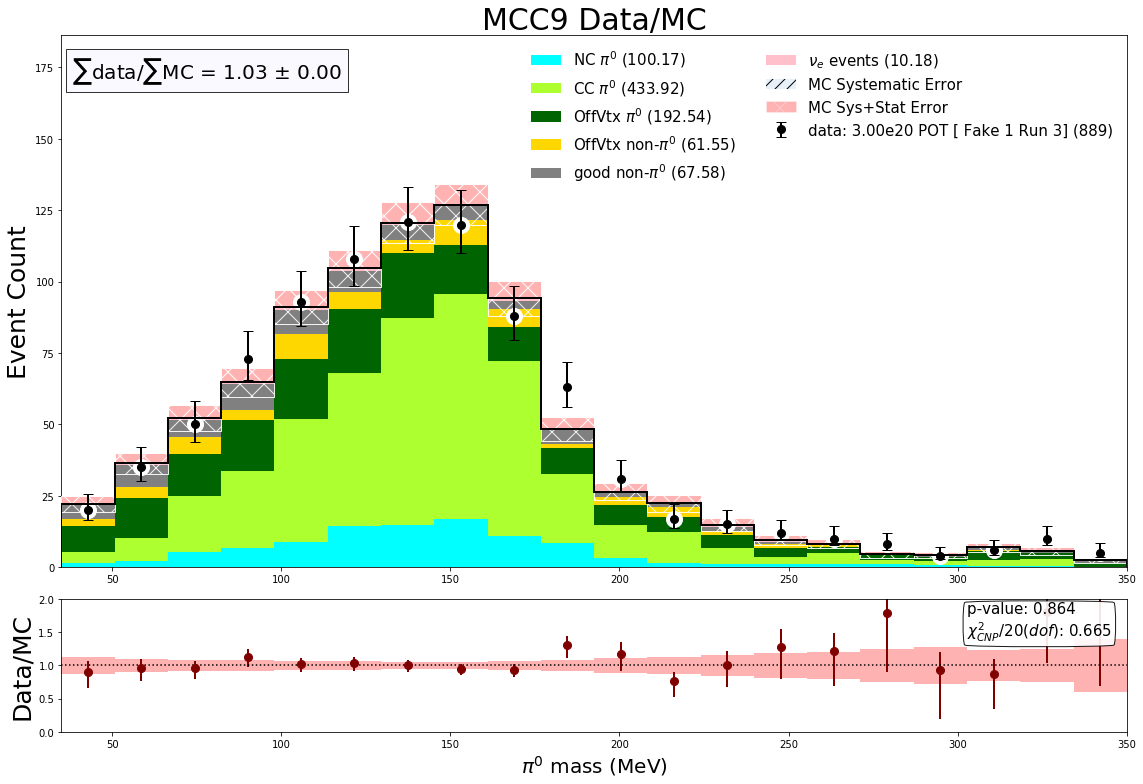

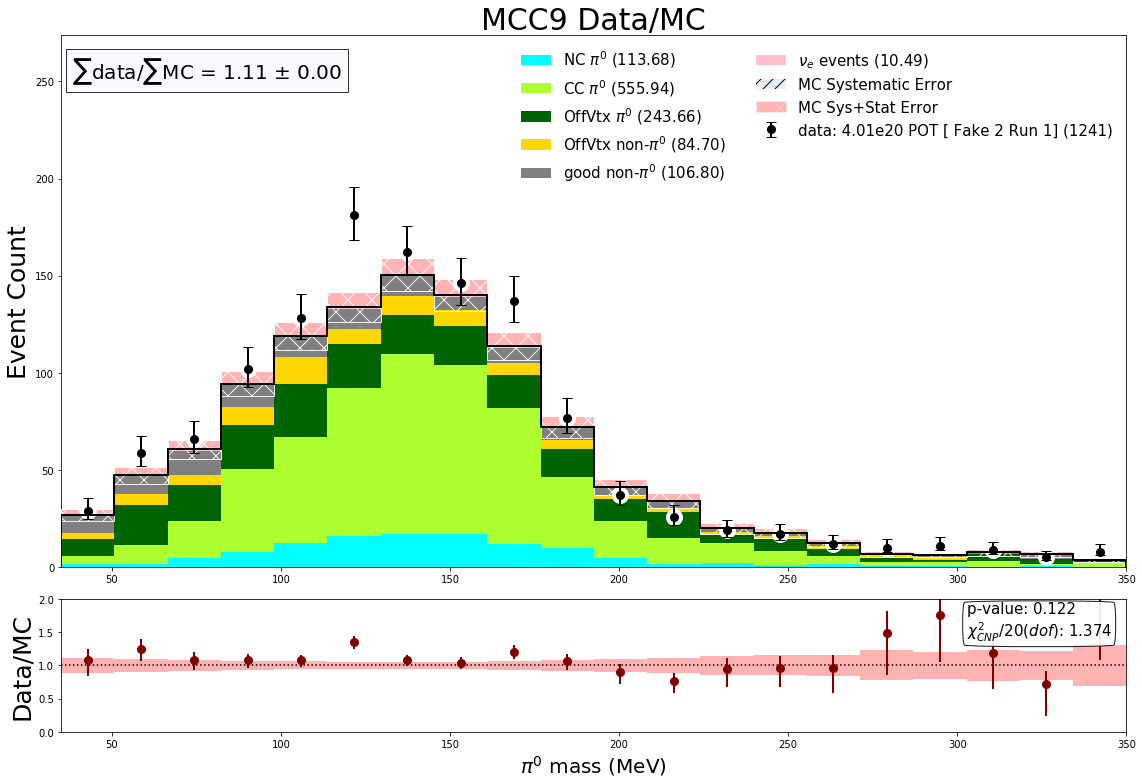

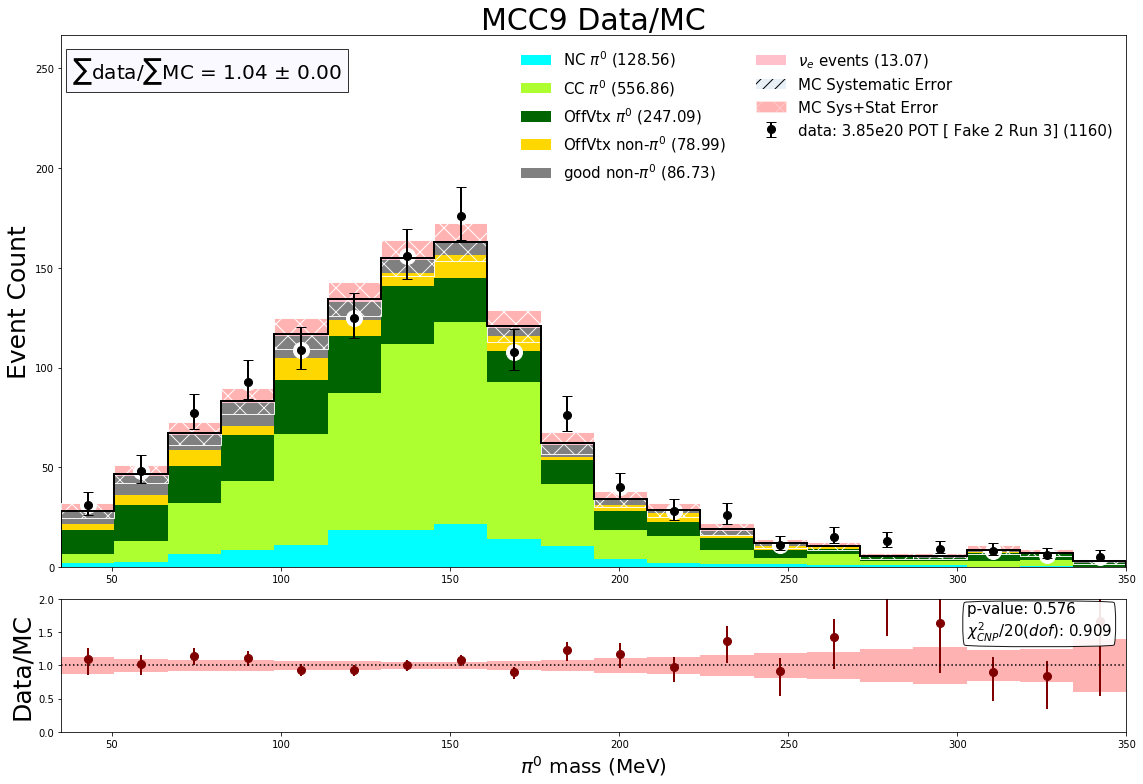

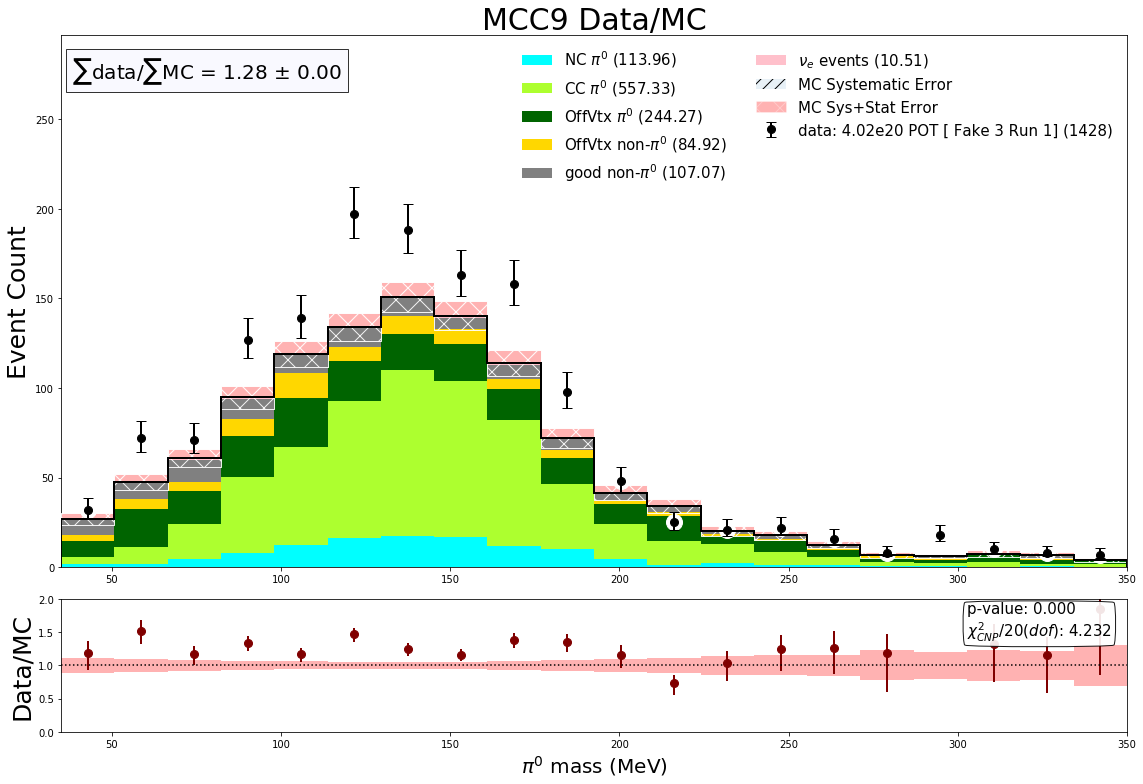

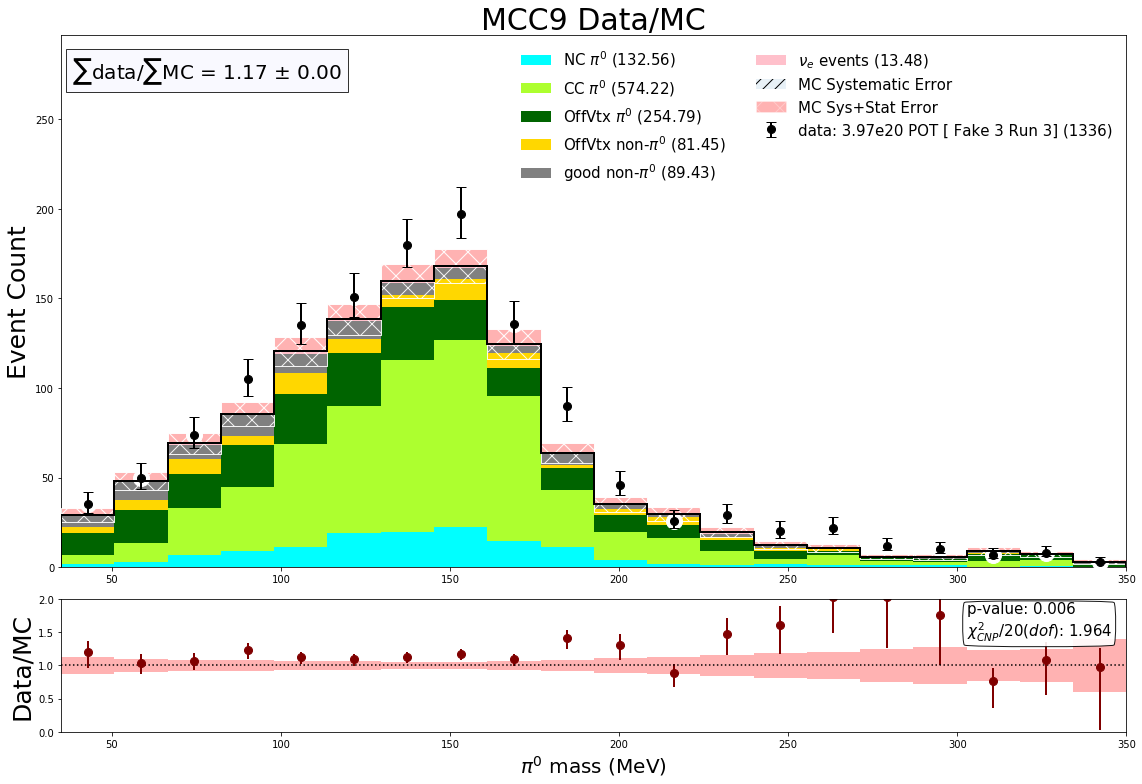

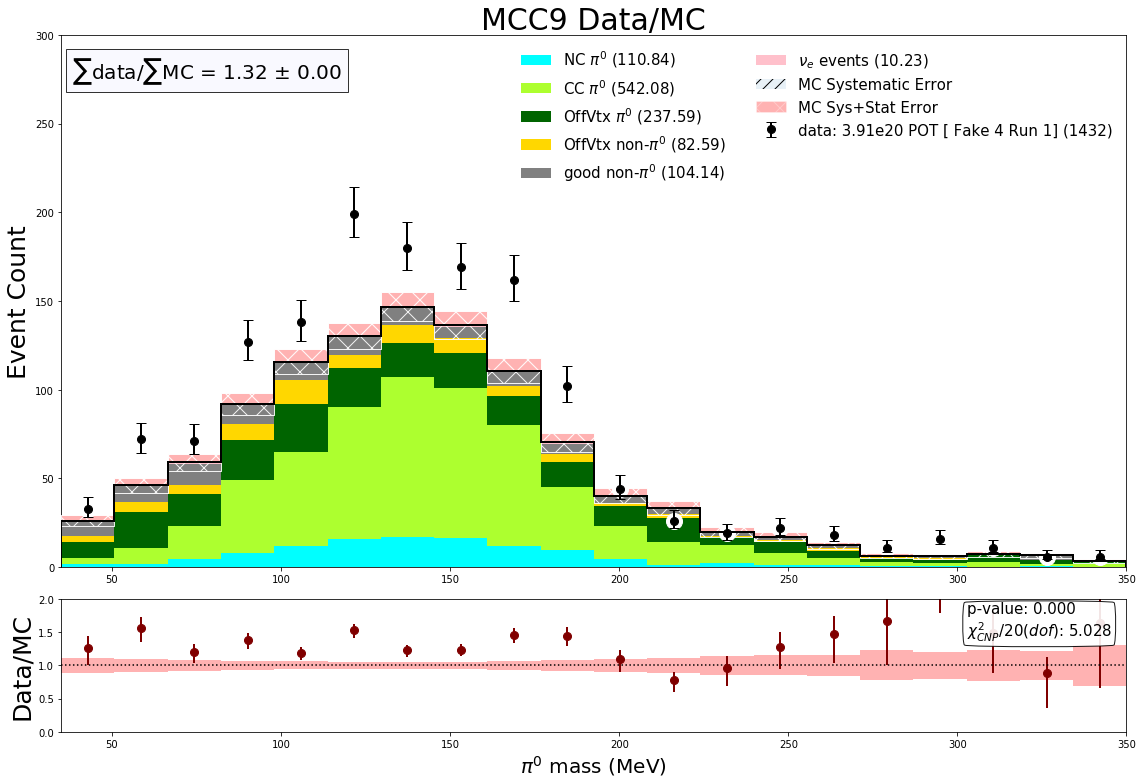

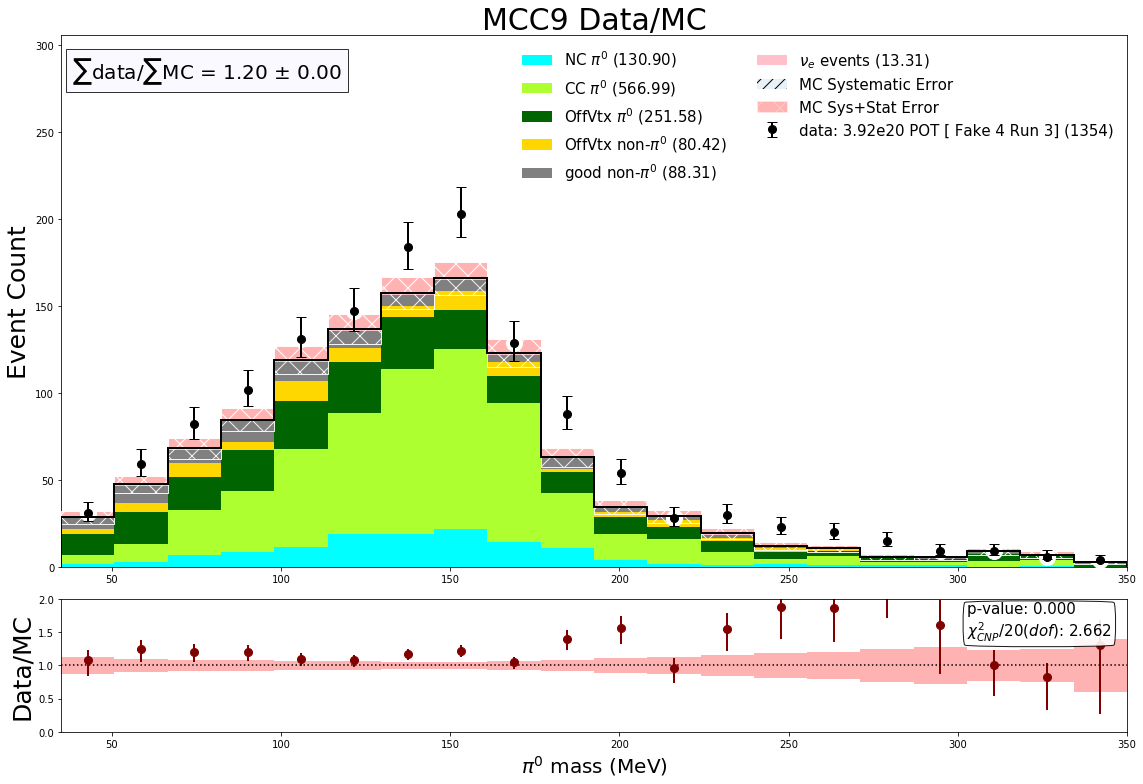

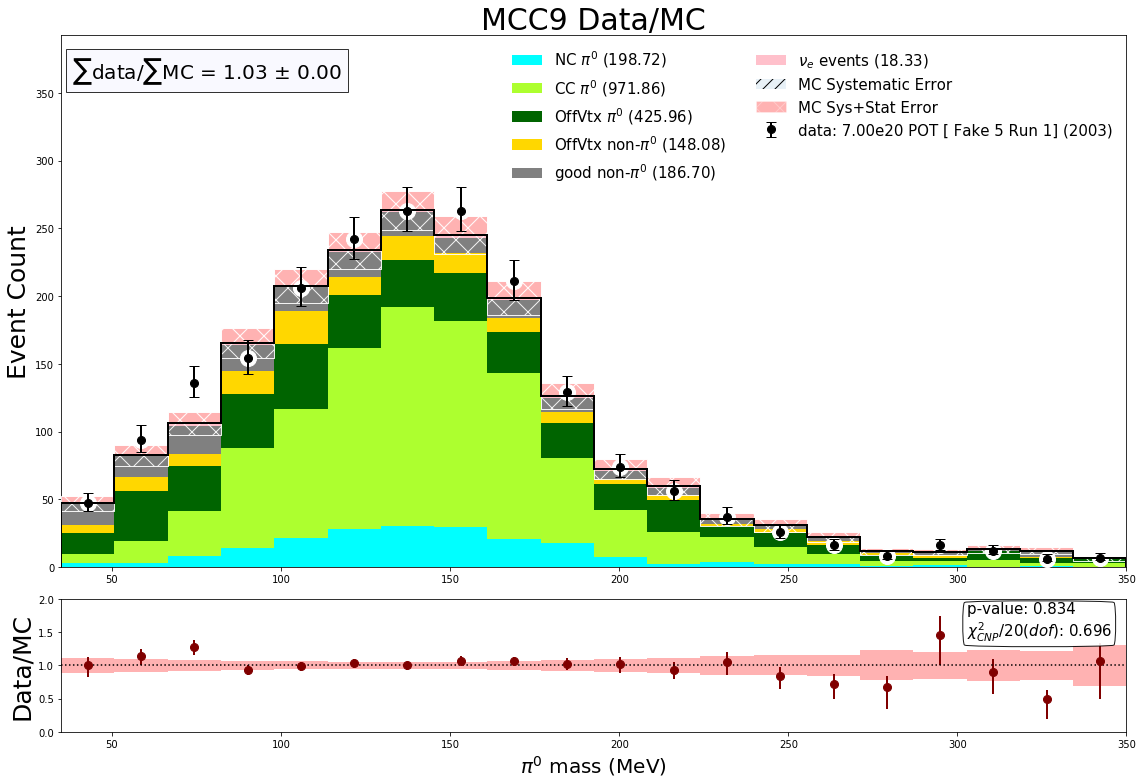

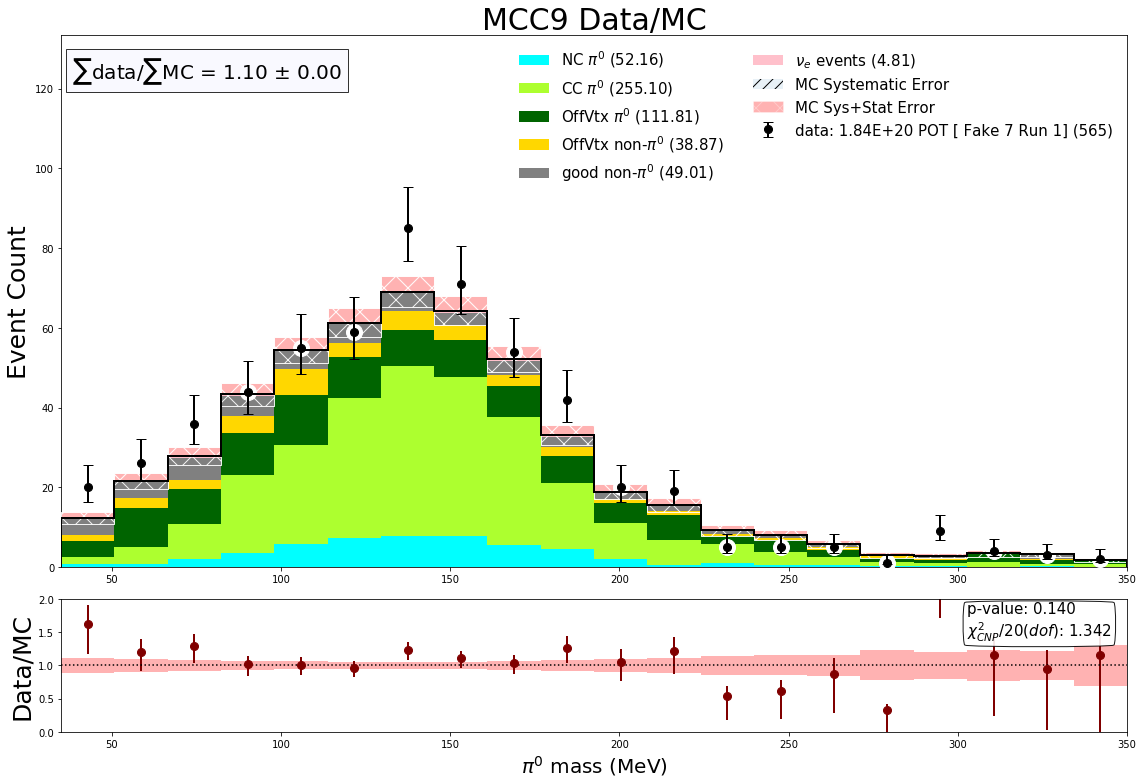

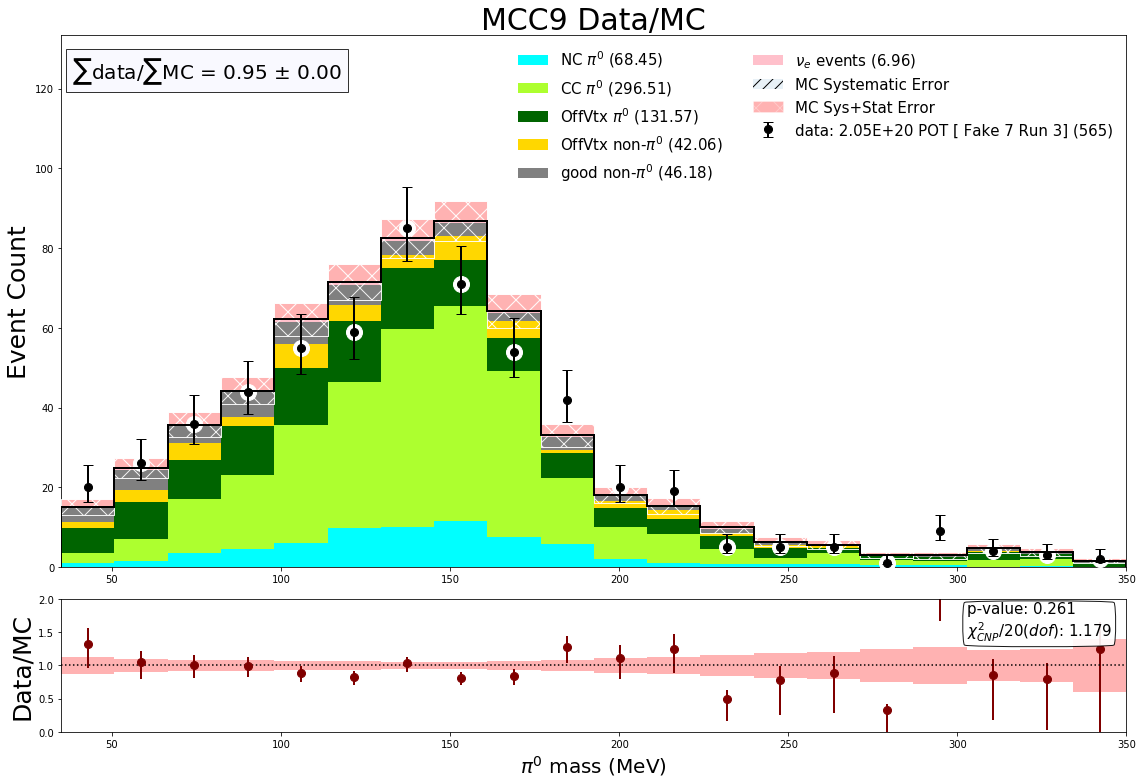

In [9]:
# plot all of the seperate pi0 mass distributions
vartest = '_pi0mass'
varname = r'$\pi^0$ mass (MeV)'
myrange = (35,350)
nbins = 20
norm = 1.0

s_cov = np.zeros((nbins,nbins))
run1_fake1_Hists = StackedHisto((df_numu_pi0.query('newhaspi0==0'),df_nue_pi0,df_ccpi0_r1_pi0,df_ncpi0_r1_pi0),(NUMU_R1_FAKE1_SCALE,NUE_R1_FAKE1_SCALE,CCPI0_R1_FAKE1_SCALE,NCPI0_R1_FAKE1_SCALE))
run1_fake1_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
run1_fake1_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
run1_fake1_Hists.AddStrata('haspi0==1  and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
run1_fake1_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
run1_fake1_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
run1_fake1_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
run1_fake1_DataHist = SimpleHisto(df_fakedata1_run1_pi0,1.0,0,'','data: 1.925e20 POT [ Fake 1 Run 1]')
fig1,ax1,_,p = distplot_wratio_davio(vartest,nbins,myrange,run1_fake1_Hists,run1_fake1_DataHist,varname,m_cov = s_cov)
fig1.savefig('fakedata_set1_run1.png')

s_cov = np.zeros((nbins,nbins))
run3_fake1_Hists = StackedHisto((df_numu_r3_pi0.query('newhaspi0==0'),df_nue_r3_pi0,df_ccpi0_r3_pi0,df_ncpi0_r3_pi0),(NUMU_R3_FAKE1_SCALE,NUE_R3_FAKE1_SCALE,CCPI0_R3_FAKE1_SCALE,NCPI0_R3_FAKE1_SCALE))
run3_fake1_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
run3_fake1_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
run3_fake1_Hists.AddStrata('haspi0==1  and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
run3_fake1_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
run3_fake1_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
run3_fake1_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
run3_fake1_DataHist = SimpleHisto(df_fakedata1_run3_pi0,1.0,0,'','data: 3.00e20 POT [ Fake 1 Run 3]')
fig1,ax1,_,p = distplot_wratio_davio(vartest,nbins,myrange,run3_fake1_Hists,run3_fake1_DataHist,varname,m_cov = s_cov)
fig1.savefig('fakedata_set1_run3.png')

s_cov = np.zeros((nbins,nbins))
run1_fake2_Hists = StackedHisto((df_numu_pi0.query('newhaspi0==0'),df_nue_pi0,df_ccpi0_r1_pi0,df_ncpi0_r1_pi0),(NUMU_R1_FAKE2_SCALE,NUE_R1_FAKE2_SCALE,CCPI0_R1_FAKE2_SCALE,NCPI0_R1_FAKE2_SCALE))
run1_fake2_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
run1_fake2_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
run1_fake2_Hists.AddStrata('haspi0==1  and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
run1_fake2_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
run1_fake2_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
run1_fake2_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
run1_fake2_DataHist = SimpleHisto(df_fakedata2_run1_pi0,1.0,0,'','data: 4.01e20 POT [ Fake 2 Run 1]')
fig1,ax1,_,p = distplot_wratio_davio(vartest,nbins,myrange,run1_fake2_Hists,run1_fake2_DataHist,varname,m_cov = s_cov)
fig1.savefig('fakedata_set2_run1.png')

s_cov = np.zeros((nbins,nbins))
run3_fake2_Hists = StackedHisto((df_numu_r3_pi0.query('newhaspi0==0'),df_nue_r3_pi0,df_ccpi0_r3_pi0,df_ncpi0_r3_pi0),(NUMU_R3_FAKE2_SCALE,NUE_R3_FAKE2_SCALE,CCPI0_R3_FAKE2_SCALE,NCPI0_R3_FAKE2_SCALE))
run3_fake2_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
run3_fake2_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
run3_fake2_Hists.AddStrata('haspi0==1  and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
run3_fake2_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
run3_fake2_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
run3_fake2_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
run3_fake2_DataHist = SimpleHisto(df_fakedata2_run3_pi0,1.0,0,'','data: 3.85e20 POT [ Fake 2 Run 3]')
fig1,ax1,_,p = distplot_wratio_davio(vartest,nbins,myrange,run3_fake2_Hists,run3_fake2_DataHist,varname,m_cov = s_cov)
fig1.savefig('fakedata_set2_run3.png')

s_cov = np.zeros((nbins,nbins))
run1_fake3_Hists = StackedHisto((df_numu_pi0.query('newhaspi0==0'),df_nue_pi0,df_ccpi0_r1_pi0,df_ncpi0_r1_pi0),(NUMU_R1_FAKE3_SCALE,NUE_R1_FAKE3_SCALE,CCPI0_R1_FAKE3_SCALE,NCPI0_R1_FAKE3_SCALE))
run1_fake3_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
run1_fake3_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
run1_fake3_Hists.AddStrata('haspi0==1  and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
run1_fake3_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
run1_fake3_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
run1_fake3_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
run1_fake3_DataHist = SimpleHisto(df_fakedata3_run1_pi0,1.0,0,'','data: 4.02e20 POT [ Fake 3 Run 1]')
fig1,ax1,_,p = distplot_wratio_davio(vartest,nbins,myrange,run1_fake3_Hists,run1_fake3_DataHist,varname,m_cov = s_cov)
fig1.savefig('fakedata_set3_run1.png')

s_cov = np.zeros((nbins,nbins))
run3_fake3_Hists = StackedHisto((df_numu_r3_pi0.query('newhaspi0==0'),df_nue_r3_pi0,df_ccpi0_r3_pi0,df_ncpi0_r3_pi0),(NUMU_R3_FAKE3_SCALE,NUE_R3_FAKE3_SCALE,CCPI0_R3_FAKE3_SCALE,NCPI0_R3_FAKE3_SCALE))
run3_fake3_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
run3_fake3_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
run3_fake3_Hists.AddStrata('haspi0==1  and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
run3_fake3_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
run3_fake3_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
run3_fake3_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
run3_fake3_DataHist = SimpleHisto(df_fakedata3_run3_pi0,1.0,0,'','data: 3.97e20 POT [ Fake 3 Run 3]')
fig1,ax1,_,p = distplot_wratio_davio(vartest,nbins,myrange,run3_fake3_Hists,run3_fake3_DataHist,varname,m_cov = s_cov)
fig1.savefig('fakedata_set3_run3.png')

s_cov = np.zeros((nbins,nbins))
run1_fake4_Hists = StackedHisto((df_numu_pi0.query('newhaspi0==0'),df_nue_pi0,df_ccpi0_r1_pi0,df_ncpi0_r1_pi0),(NUMU_R1_FAKE4_SCALE,NUE_R1_FAKE4_SCALE,CCPI0_R1_FAKE4_SCALE,NCPI0_R1_FAKE4_SCALE))
run1_fake4_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
run1_fake4_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
run1_fake4_Hists.AddStrata('haspi0==1  and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
run1_fake4_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
run1_fake4_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
run1_fake4_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
run1_fake4_DataHist = SimpleHisto(df_fakedata4_run1_pi0,1.0,0,'','data: 3.91e20 POT [ Fake 4 Run 1]')
fig1,ax1,_,p = distplot_wratio_davio(vartest,nbins,myrange,run1_fake4_Hists,run1_fake4_DataHist,varname,m_cov = s_cov)
fig1.savefig('fakedata_set4_run1.png')

s_cov = np.zeros((nbins,nbins))
run3_fake4_Hists = StackedHisto((df_numu_r3_pi0.query('newhaspi0==0'),df_nue_r3_pi0,df_ccpi0_r3_pi0,df_ncpi0_r3_pi0),(NUMU_R3_FAKE4_SCALE,NUE_R3_FAKE4_SCALE,CCPI0_R3_FAKE4_SCALE,NCPI0_R3_FAKE4_SCALE))
run3_fake4_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
run3_fake4_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
run3_fake4_Hists.AddStrata('haspi0==1  and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
run3_fake4_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
run3_fake4_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
run3_fake4_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
run3_fake4_DataHist = SimpleHisto(df_fakedata4_run3_pi0,1.0,0,'','data: 3.92e20 POT [ Fake 4 Run 3]')
fig1,ax1,_,p = distplot_wratio_davio(vartest,nbins,myrange,run3_fake4_Hists,run3_fake4_DataHist,varname,m_cov = s_cov)
fig1.savefig('fakedata_set4_run3.png')

s_cov = np.zeros((nbins,nbins))
run1_fake5_Hists = StackedHisto((df_numu_pi0.query('newhaspi0==0'),df_nue_pi0,df_ccpi0_r1_pi0,df_ncpi0_r1_pi0),(NUMU_R1_FAKE5_SCALE,NUE_R1_FAKE5_SCALE,CCPI0_R1_FAKE5_SCALE,NCPI0_R1_FAKE5_SCALE))
run1_fake5_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
run1_fake5_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
run1_fake5_Hists.AddStrata('haspi0==1  and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
run1_fake5_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
run1_fake5_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
run1_fake5_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
run1_fake5_DataHist = SimpleHisto(df_fakedata5_run1_pi0,1.0,0,'','data: 7.00e20 POT [ Fake 5 Run 1]')
fig1,ax1,_,p = distplot_wratio_davio(vartest,nbins,myrange,run1_fake5_Hists,run1_fake5_DataHist,varname,m_cov = s_cov)
fig1.savefig('fakedata_set5_run1.png')

s_cov = np.zeros((nbins,nbins))
run1_fake7_Hists = StackedHisto((df_numu_pi0.query('newhaspi0==0'),df_nue_pi0,df_ccpi0_r1_pi0,df_ncpi0_r1_pi0),(NUMU_R1_FAKE7_SCALE,NUE_R1_FAKE7_SCALE,CCPI0_R1_FAKE7_SCALE,NCPI0_R1_FAKE7_SCALE))
run1_fake7_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
run1_fake7_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
run1_fake7_Hists.AddStrata('haspi0==1  and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
run1_fake7_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
run1_fake7_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
run1_fake7_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
run1_fake7_DataHist = SimpleHisto(df_fakedata7_run1_pi0,1.0,0,'','data: 1.84E+20 POT [ Fake 7 Run 1]')
fig1,ax1,_,p = distplot_wratio_davio(vartest,nbins,myrange,run1_fake7_Hists,run1_fake7_DataHist,varname,m_cov = s_cov)
fig1.savefig('fakedata_set7_run1.png')

s_cov = np.zeros((nbins,nbins))
run3_fake7_Hists = StackedHisto((df_numu_r3_pi0.query('newhaspi0==0'),df_nue_r3_pi0,df_ccpi0_r3_pi0,df_ncpi0_r3_pi0),(NUMU_R3_FAKE7_SCALE,NUE_R3_FAKE7_SCALE,CCPI0_R3_FAKE7_SCALE,NCPI0_R3_FAKE7_SCALE))
run3_fake7_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
run3_fake7_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
run3_fake7_Hists.AddStrata('haspi0==1  and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
run3_fake7_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
run3_fake7_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
run3_fake7_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
run3_fake7_DataHist = SimpleHisto(df_fakedata7_run3_pi0,1.0,0,'','data: 2.05E+20 POT [ Fake 7 Run 3]')
fig1,ax1,_,p = distplot_wratio_davio(vartest,nbins,myrange,run3_fake7_Hists,run3_fake7_DataHist,varname,m_cov = s_cov)
fig1.savefig('fakedata_set7_run3.png')

In [10]:
# plot all of the seperate pi0  distributions
vartest_list = []
varname_list = []
myrange_list = []
detvar1_list  = []
detvar3_list  = []
sys_list = []
bins_list = []

vartest_list.append('_pi0mass_new')
varname_list.append('Pi0 mass (MeV)')
myrange_list.append((30.0,350.0))
sys_list.append('../systematics/covar_cv_weighted__pi0_mass_reco.txt')
detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys__pi0mass_new_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys__pi0mass_new_run3_cov.csv')
bins_list.append(20)

vartest_list.append('DeltaMass_new')
varname_list.append('Delta mass (MeV)')
myrange_list.append((1000,1400))
detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_DeltaMass_new_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_DeltaMass_new_run3_cov.csv')
sys_list.append('../systematics/covar_cv_weighted__Delta_mass_reco.txt')
bins_list.append(20)

vartest_list.append('pi0_energy_reco_new')
varname_list.append('Pi0 Energy (MeV)')
myrange_list.append((100.0,750.0))
detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_pi0_energy_reco_new_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_pi0_energy_reco_new_run3_cov.csv')
sys_list.append('../systematics/covar_cv_weighted__pi0_energy_reco.txt')
bins_list.append(20)

vartest_list.append('pi0_momentum_reco_new')
varname_list.append('Pi0 Momentum (MeV)')
myrange_list.append((100.0,700.0))
detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_pi0_momentum_reco_new_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_pi0_momentum_reco_new_run3_cov.csv')
sys_list.append('../systematics/covar_cv_weighted__pi0_momentum_reco.txt')
bins_list.append(20)

vartest_list.append('shower1_E_Y_new')
varname_list.append('shower1 energy (MeV)')
myrange_list.append((80.0,450.0))
detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_shower1_E_Y_new_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_shower1_E_Y_new_run3_cov.csv')
sys_list.append('../systematics/covar_cv_weighted__shower1_energy_reco.txt')
bins_list.append(20)

vartest_list.append('shower2_E_Y_new')
varname_list.append('shower2 energy (MeV)')
myrange_list.append((35.0,300.0))
detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_shower2_E_Y_new_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_shower2_E_Y_new_run3_cov.csv')
sys_list.append('../systematics/covar_cv_weighted__shower2_energy_reco.txt')
bins_list.append(20)

In [11]:
# add all of the data frames
df_data_total_1 = df_fakedata1_run1_pi0.append(df_fakedata1_run3_pi0)
df_data_total_2 = df_fakedata2_run1_pi0.append(df_fakedata2_run3_pi0)
df_data_total_3 = df_fakedata3_run1_pi0.append(df_fakedata3_run3_pi0)
df_data_total_4 = df_fakedata4_run1_pi0.append(df_fakedata4_run3_pi0)
df_data_total_7 = df_fakedata7_run1_pi0.append(df_fakedata7_run3_pi0)

def potscale(df,scalefactor=1.0,ext=False):
    pot_weight = []
    for i in range(len(df)):
        if ext==False:
            pot_weight.append(scalefactor)
        else:
            pot_weight.append(scalefactor)
    return pot_weight

# general mc
w_mu_1 =potscale(df_numu_pi0,FAKE_DATA_1_RUN1_POT/NUMU_R1_POT)
w_mu_3 =potscale(df_numu_r3_pi0,FAKE_DATA_1_RUN3_POT/NUMU_R3_POT)
df_numu_pi0['pot_weight'] = w_mu_1
df_numu_r3_pi0['pot_weight'] = w_mu_3

df_numu_total = df_numu_pi0.append(df_numu_r3_pi0)

w_e_1 =potscale(df_nue_pi0,FAKE_DATA_1_RUN1_POT/NUE_R1_POT)
w_e_3 =potscale(df_nue_r3_pi0,FAKE_DATA_1_RUN3_POT/NUE_R3_POT)
df_nue_pi0['pot_weight'] = w_e_1
df_nue_r3_pi0['pot_weight'] = w_e_3
df_nue_total = df_nue_pi0.append(df_nue_r3_pi0)

w_cc_1 =potscale(df_ccpi0_r1_pi0,FAKE_DATA_1_RUN1_POT/CCPI0_R1_POT)
w_cc_3 =potscale(df_ccpi0_r3_pi0,FAKE_DATA_1_RUN3_POT/(CCPI0_R3_POT))
df_ccpi0_r1_pi0['pot_weight'] = w_cc_1
df_ccpi0_r3_pi0['pot_weight'] = w_cc_3
df_ccpi0_total = df_ccpi0_r1_pi0.append(df_ccpi0_r3_pi0)

w_nc_1 =potscale(df_ncpi0_r1_pi0,FAKE_DATA_1_RUN1_POT/NCPI0_R1_POT)
w_nc_3 =potscale(df_ncpi0_r3_pi0,FAKE_DATA_1_RUN3_POT/(NCPI0_R3_POT))
df_ncpi0_r1_pi0['pot_weight'] = w_nc_1
df_ncpi0_r3_pi0['pot_weight'] = w_nc_3
df_ncpi0_total = df_ncpi0_r1_pi0.append(df_ncpi0_r3_pi0)

/home/kmason/.local/lib/python3.5/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [12]:
NUMU_POT_TOTAL = NUMU_R1_POT+NUMU_R3_POT
NUE_POT_TOTAL = NUE_R1_POT+NUE_R3_POT
CCPI0_POT_TOTAL = CCPI0_R1_POT+CCPI0_R3_POT
NCPI0_POT_TOTAL = NCPI0_R1_POT+NCPI0_R3a_POT+NCPI0_R3b_POT

DATA_POT_TOTAL_1 = FAKE_DATA_1_RUN1_POT + FAKE_DATA_1_RUN3_POT
DATA_POT_TOTAL_2 = FAKE_DATA_2_RUN1_POT + FAKE_DATA_2_RUN3_POT
DATA_POT_TOTAL_3 = FAKE_DATA_3_RUN1_POT + FAKE_DATA_3_RUN3_POT
DATA_POT_TOTAL_4 = FAKE_DATA_4_RUN1_POT + FAKE_DATA_4_RUN3_POT
DATA_POT_TOTAL_7 = FAKE_DATA_7_RUN1_POT + FAKE_DATA_7_RUN3_POT

POT_SCALE_FACTOR_1 = DATA_POT_TOTAL_1 *1.0
POT_SCALE_FACTOR_2 = DATA_POT_TOTAL_2 *1.0
POT_SCALE_FACTOR_3 = DATA_POT_TOTAL_3 *1.0
POT_SCALE_FACTOR_4 = DATA_POT_TOTAL_4 *1.0
POT_SCALE_FACTOR_7 = DATA_POT_TOTAL_7 *1.0

NUMU_SCALE_TOTAL_1 = POT_SCALE_FACTOR_1 / float(NUMU_POT_TOTAL)
NUMU_SCALE_TOTAL_2 = POT_SCALE_FACTOR_2 / float(NUMU_POT_TOTAL)
NUMU_SCALE_TOTAL_3 = POT_SCALE_FACTOR_3 / float(NUMU_POT_TOTAL)
NUMU_SCALE_TOTAL_4 = POT_SCALE_FACTOR_4 / float(NUMU_POT_TOTAL)
NUMU_SCALE_TOTAL_7 = POT_SCALE_FACTOR_7 / float(NUMU_POT_TOTAL)

NUE_SCALE_TOTAL_1 = POT_SCALE_FACTOR_1/ float(NUE_POT_TOTAL)
NUE_SCALE_TOTAL_2 = POT_SCALE_FACTOR_2 / float(NUE_POT_TOTAL)
NUE_SCALE_TOTAL_3 = POT_SCALE_FACTOR_3 / float(NUE_POT_TOTAL)
NUE_SCALE_TOTAL_4 = POT_SCALE_FACTOR_4 / float(NUE_POT_TOTAL)
NUE_SCALE_TOTAL_7 = POT_SCALE_FACTOR_7 / float(NUE_POT_TOTAL)

CCPI0_SCALE_TOTAL_1 = POT_SCALE_FACTOR_1/ float(CCPI0_POT_TOTAL)
CCPI0_SCALE_TOTAL_2 = POT_SCALE_FACTOR_2 / float(CCPI0_POT_TOTAL)
CCPI0_SCALE_TOTAL_3 = POT_SCALE_FACTOR_3 / float(CCPI0_POT_TOTAL)
CCPI0_SCALE_TOTAL_4 = POT_SCALE_FACTOR_4 / float(CCPI0_POT_TOTAL)
CCPI0_SCALE_TOTAL_7 = POT_SCALE_FACTOR_7 / float(CCPI0_POT_TOTAL)

NCPI0_SCALE_TOTAL_1 = POT_SCALE_FACTOR_1/ float(NCPI0_POT_TOTAL)
NCPI0_SCALE_TOTAL_2 = POT_SCALE_FACTOR_2 / float(NCPI0_POT_TOTAL)
NCPI0_SCALE_TOTAL_3 = POT_SCALE_FACTOR_3 / float(NCPI0_POT_TOTAL)
NCPI0_SCALE_TOTAL_4 = POT_SCALE_FACTOR_4 / float(NCPI0_POT_TOTAL)
NCPI0_SCALE_TOTAL_7 = POT_SCALE_FACTOR_7 / float(NCPI0_POT_TOTAL)

DATA_SCALE_TOTAL_1 = POT_SCALE_FACTOR_1 / float(DATA_POT_TOTAL_1)
DATA_SCALE_TOTAL_2 = POT_SCALE_FACTOR_2 / float(DATA_POT_TOTAL_2)
DATA_SCALE_TOTAL_3 = POT_SCALE_FACTOR_3 / float(DATA_POT_TOTAL_3)
DATA_SCALE_TOTAL_4 = POT_SCALE_FACTOR_4 / float(DATA_POT_TOTAL_4)
DATA_SCALE_TOTAL_7 = POT_SCALE_FACTOR_7 / float(DATA_POT_TOTAL_7)

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.22097439 0.22097439 0.22097439 ... 0.00340463 0.00340463 0.00340463]
Normalization Uncertainty: 0.23164982793524785
1.080360582462137 0.3621989689826839
hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.35159082 0.35159082 0.35159082 ... 0.00541709 0.00541709 0.00541709]
Normalization Uncertainty: 0.23079111569836847
1.0222353431530455 0.43043812184957886
hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.35740594 0.35740594 0.35740594 ... 0.00550668 0.00550668 0.00550668]
Normalization Uncertainty: 0.23084273782595824
1.4179918329415442 0.10115118545649837
hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.35024887 0.35024887 0.35024887 ... 0.00539641 0.00539641 0.00539641]
Normalization Uncertainty: 0.230

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.22097439 0.22097439 0.22097439 ... 0.00340463 0.00340463 0.00340463]
Normalization Uncertainty: 0.22889462739180244
0.789399709241988 0.7296865668794077
hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.35159082 0.35159082 0.35159082 ... 0.00541709 0.00541709 0.00541709]
Normalization Uncertainty: 0.22880977793656462
1.144952449263774 0.29377860791813015
hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.35740594 0.35740594 0.35740594 ... 0.00550668 0.00550668 0.00550668]
Normalization Uncertainty: 0.22881487071006748
1.2096126261272087 0.2340950463138578
hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.35024887 0.35024887 0.35024887 ... 0.00539641 0.00539641 0.00539641]
Normalization Uncertainty: 0.22881

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.22097439 0.22097439 0.22097439 ... 0.00340463 0.00340463 0.00340463]
Normalization Uncertainty: 0.23159621854731555
0.5499772057881638 0.9462343520385299
hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.35159082 0.35159082 0.35159082 ... 0.00541709 0.00541709 0.00541709]
Normalization Uncertainty: 0.23121500942344672
0.48801009912211457 0.9723145916445548
hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.35740594 0.35740594 0.35740594 ... 0.00550668 0.00550668 0.00550668]
Normalization Uncertainty: 0.231237903823785
0.6744078607097338 0.8554713877993421
hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.35024887 0.35024887 0.35024887 ... 0.00539641 0.00539641 0.00539641]
Normalization Uncertainty: 0.23125

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.22097439 0.22097439 0.22097439 ... 0.00340463 0.00340463 0.00340463]
Normalization Uncertainty: 0.23040331977132164
0.36080135709273525 0.9959140827386966
hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.35159082 0.35159082 0.35159082 ... 0.00541709 0.00541709 0.00541709]
Normalization Uncertainty: 0.22985040454650496
0.4366759296283341 0.9857932220828534
hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.35740594 0.35740594 0.35740594 ... 0.00550668 0.00550668 0.00550668]
Normalization Uncertainty: 0.22988362295564954
0.6075735591411546 0.9107637627283414


/home/kmason/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.35024887 0.35024887 0.35024887 ... 0.00539641 0.00539641 0.00539641]
Normalization Uncertainty: 0.2299013747201332
0.6933987259551635 0.8371263208388944
hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.17400615 0.17400615 0.17400615 ... 0.00268098 0.00268098 0.00268098]
Normalization Uncertainty: 0.2300255109024127
3.1134342750029984 3.15508853687696e-06
hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.52439444 0.52439444 0.52439444 ... 0.24139035 0.24139035 0.24139035]
Normalization Uncertainty: 0.20874163160591905
1.5112974312942753 0.06627427491567772


/home/kmason/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.22097439 0.22097439 0.22097439 ... 0.00340463 0.00340463 0.00340463]
Normalization Uncertainty: 0.2325513730326578
0.6153059031015883 0.9051367218345606
hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.35159082 0.35159082 0.35159082 ... 0.00541709 0.00541709 0.00541709]
Normalization Uncertainty: 0.23193138525590923
0.6475382770790443 0.8794864646014504
hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.35740594 0.35740594 0.35740594 ... 0.00550668 0.00550668 0.00550668]
Normalization Uncertainty: 0.2319686379726291
0.6656611309845439 0.8635441627976754
hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.35024887 0.35024887 0.35024887 ... 0.00539641 0.00539641 0.00539641]
Normalization Uncertainty: 0.231988

/home/kmason/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.22097439 0.22097439 0.22097439 ... 0.00340463 0.00340463 0.00340463]
Normalization Uncertainty: 0.22922637959690767
0.8152629626017476 0.6975150213711473
hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.35159082 0.35159082 0.35159082 ... 0.00541709 0.00541709 0.00541709]
Normalization Uncertainty: 0.22964136956425282
0.5320327327399427 0.9550144953548374
hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.35740594 0.35740594 0.35740594 ... 0.00550668 0.00550668 0.00550668]
Normalization Uncertainty: 0.22961648682678365
0.6219380960551324 0.90014697048735
hstack gh_weights [1.         1.         1.         ... 1.24525704 1.         1.        ]
hstack gh_scale [0.35024887 0.35024887 0.35024887 ... 0.00539641 0.00539641 0.00539641]
Normalization Uncertainty: 0.229603

/home/kmason/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


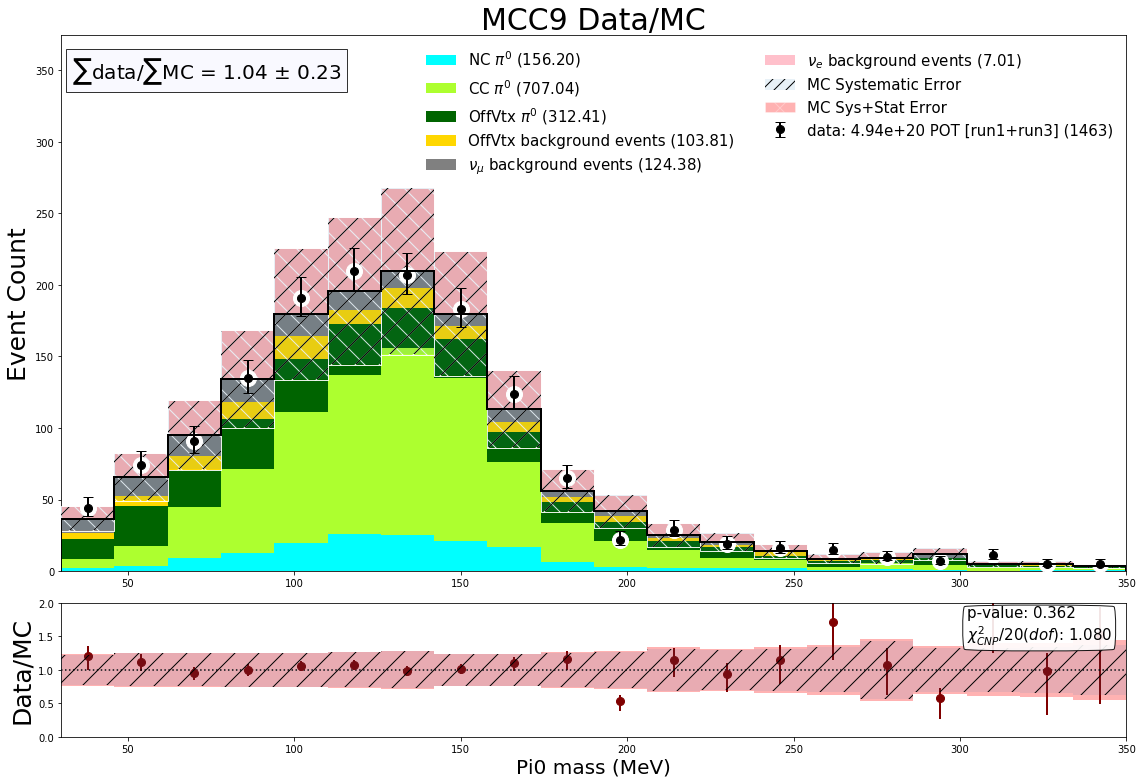

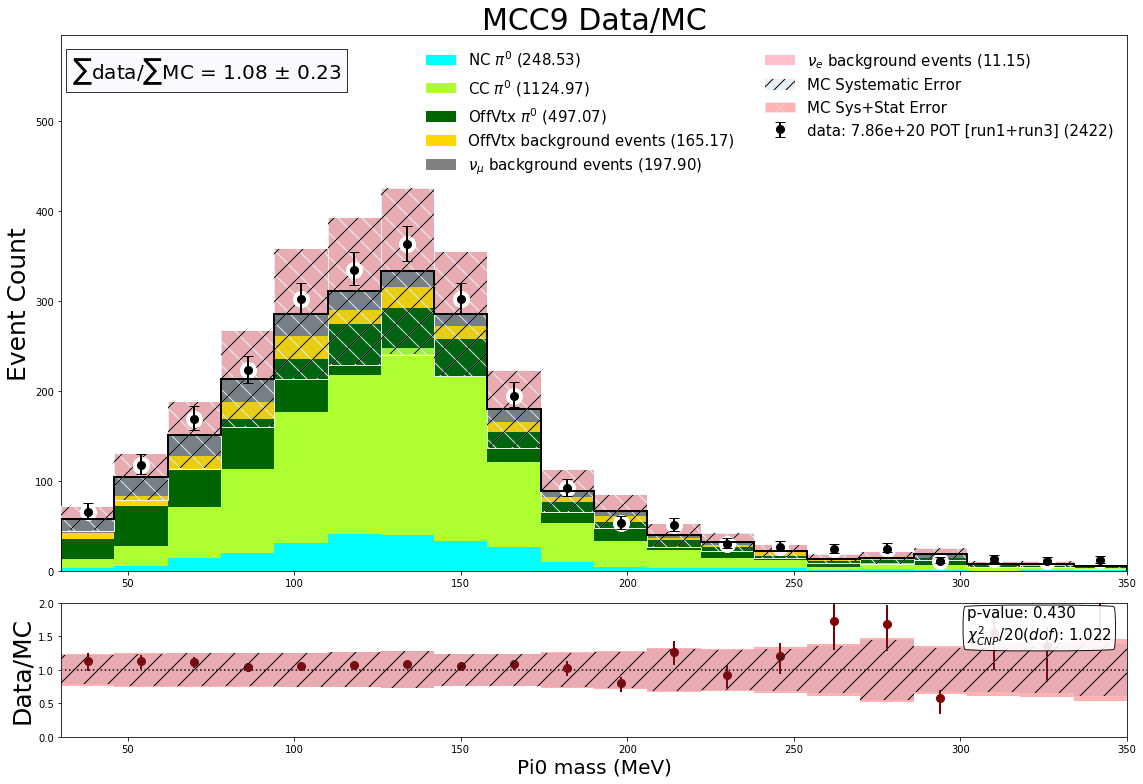

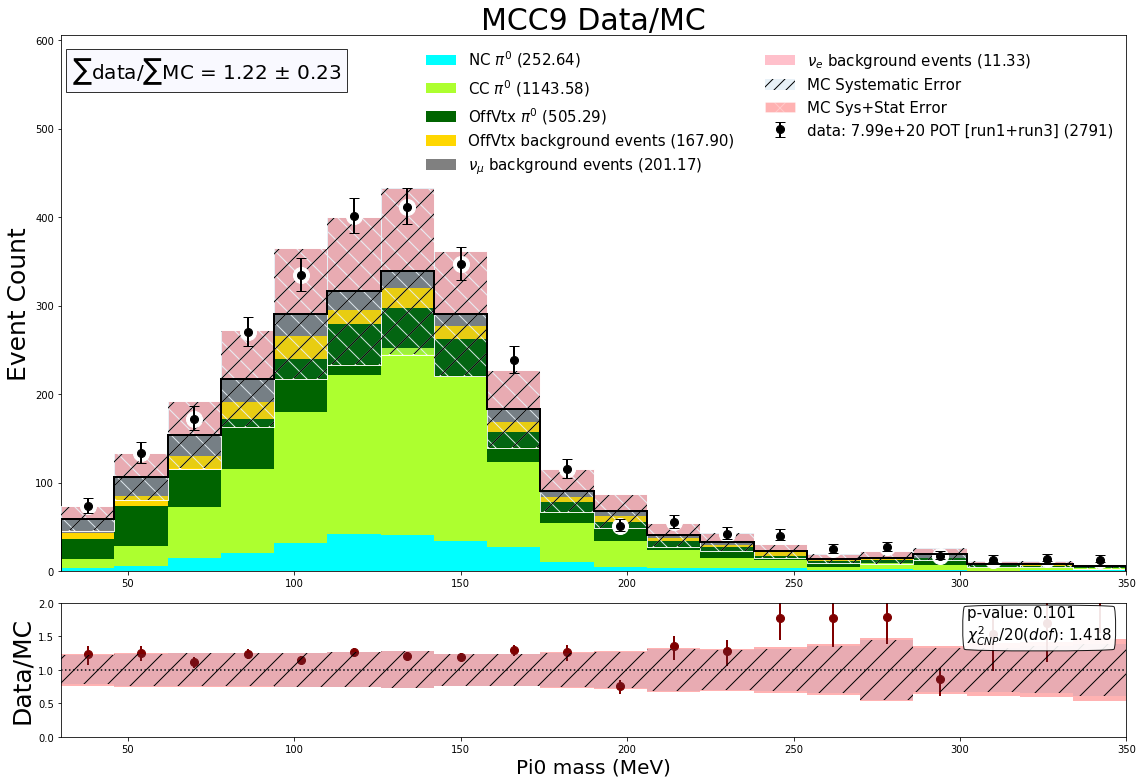

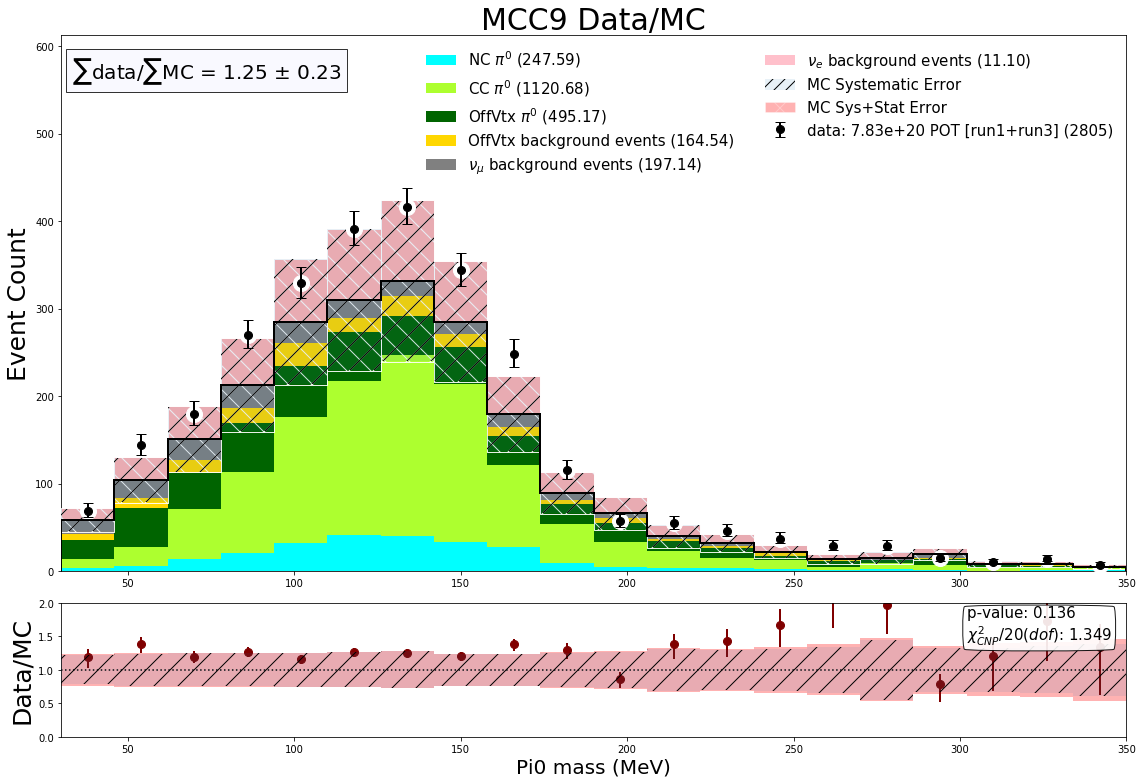

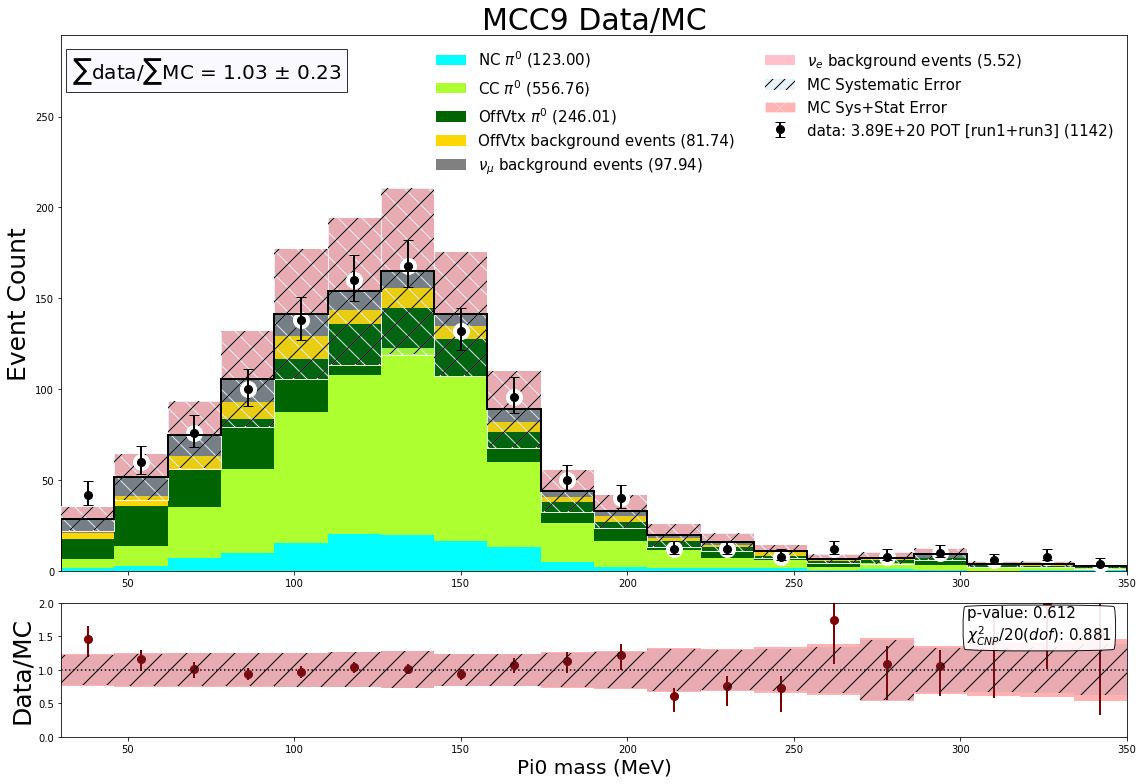

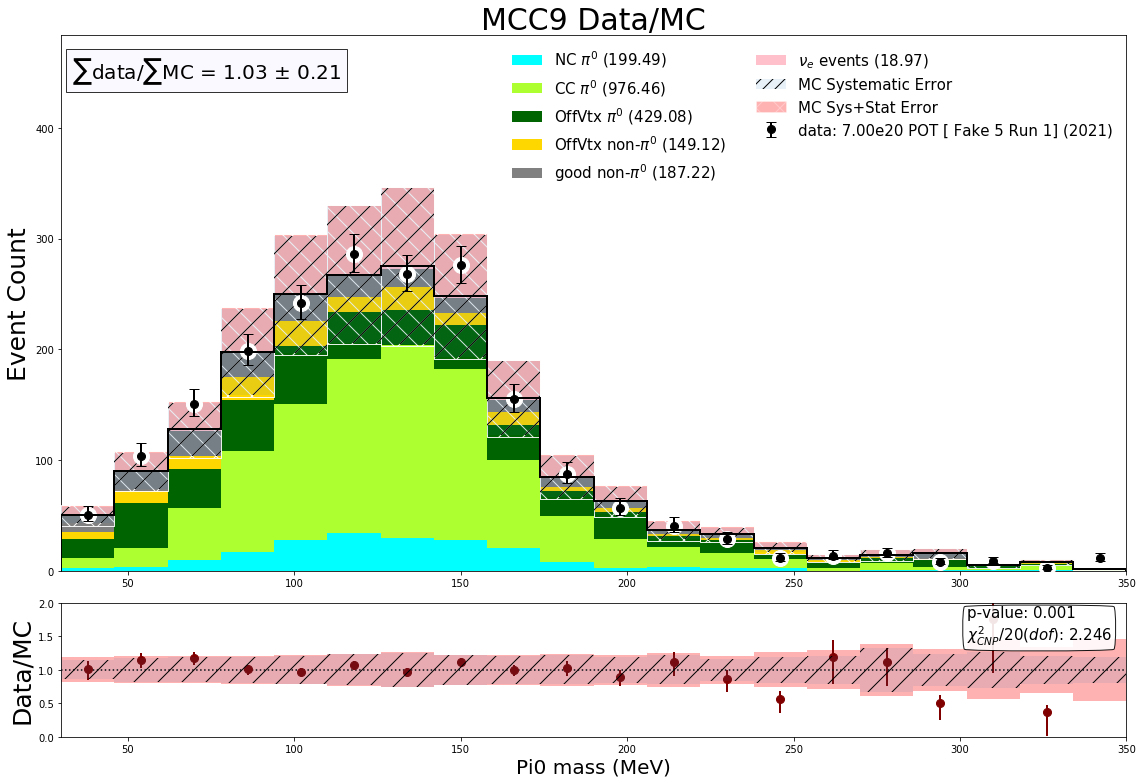

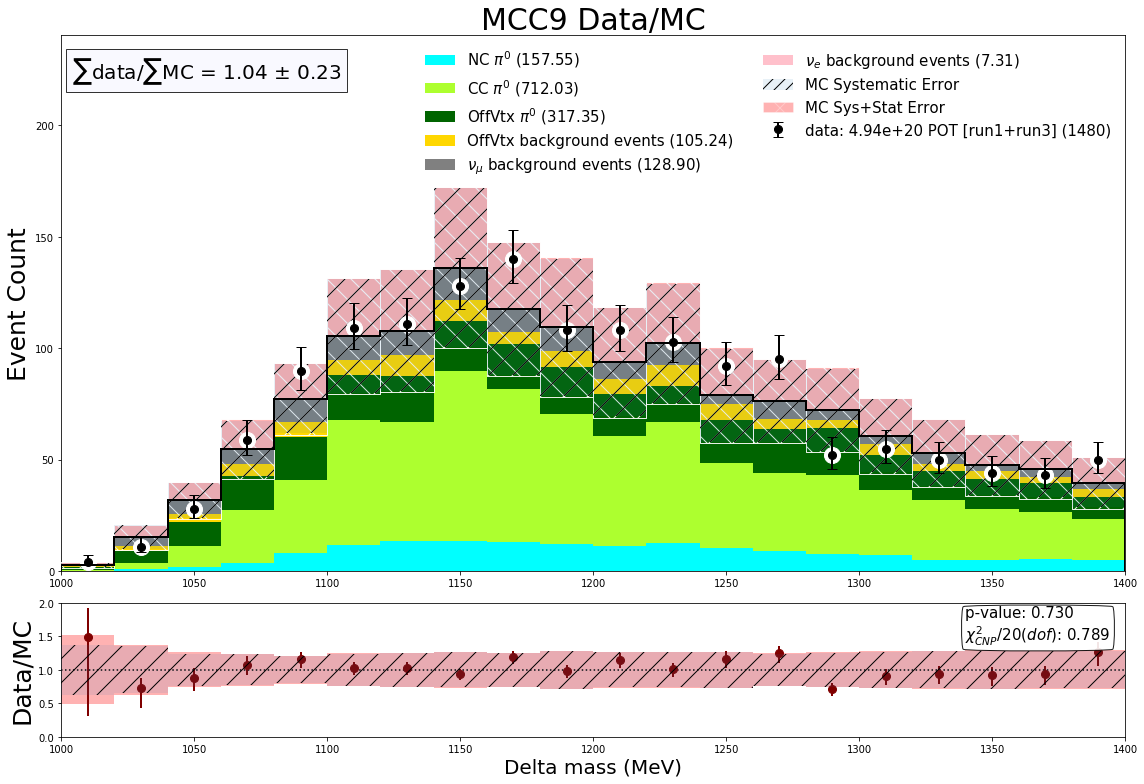

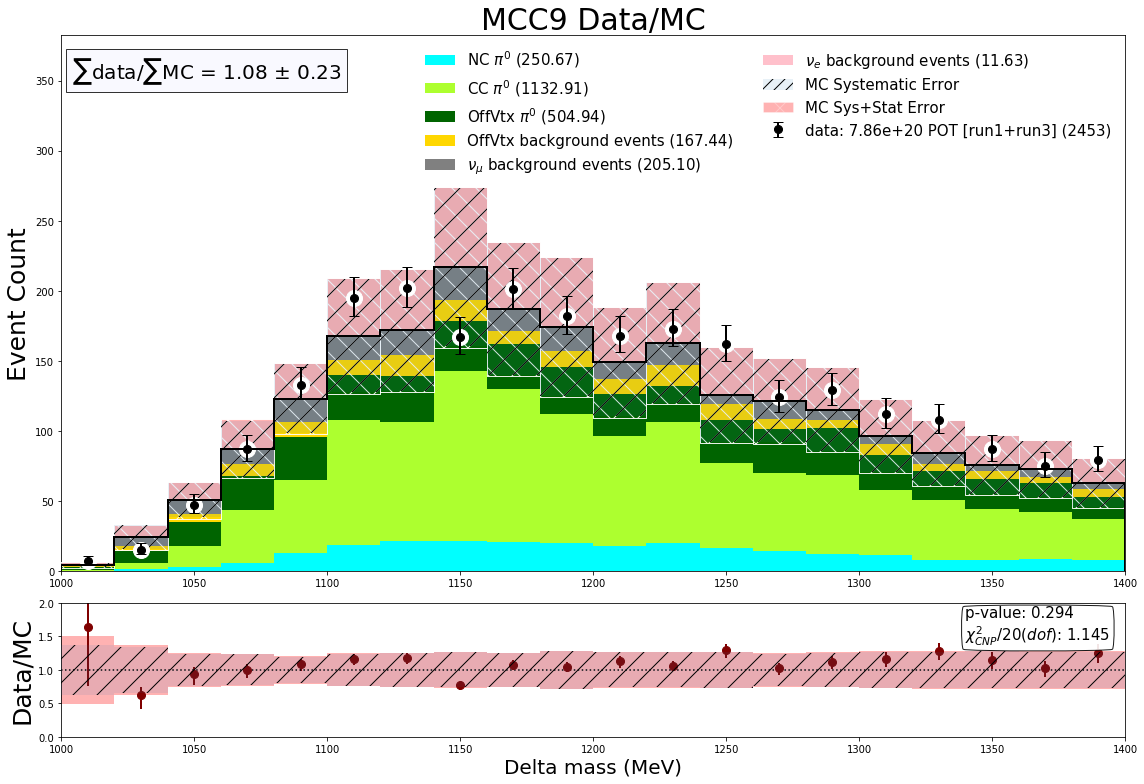

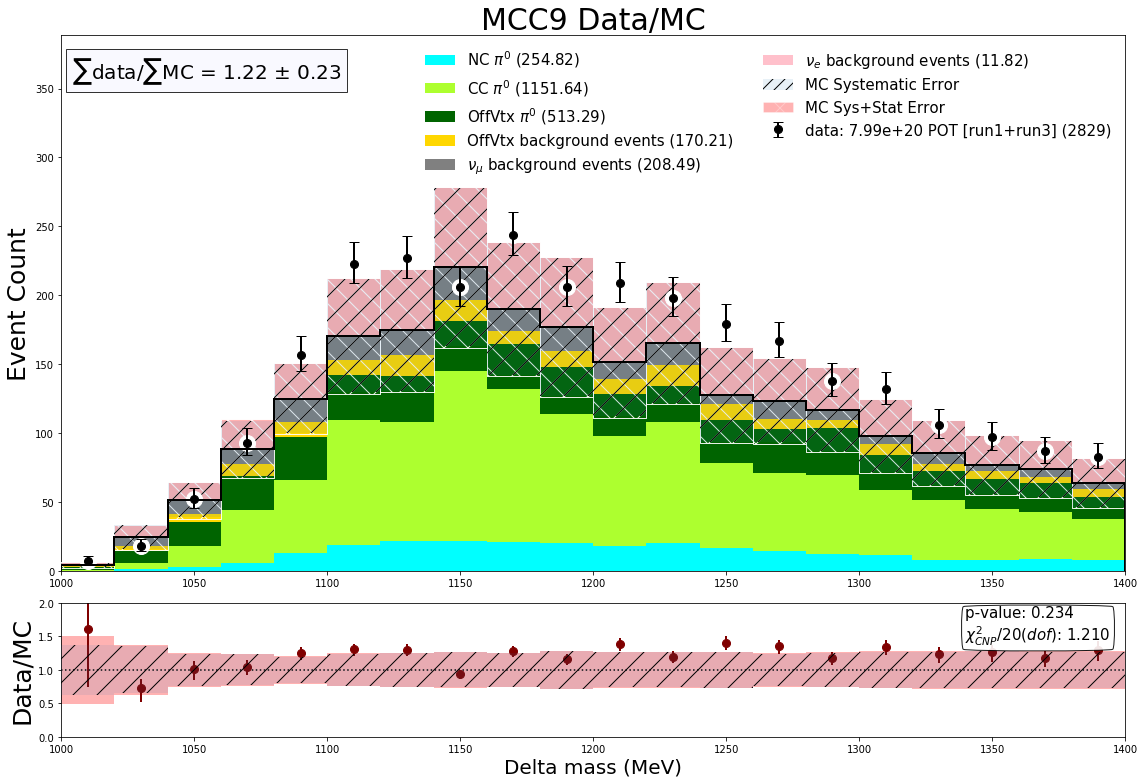

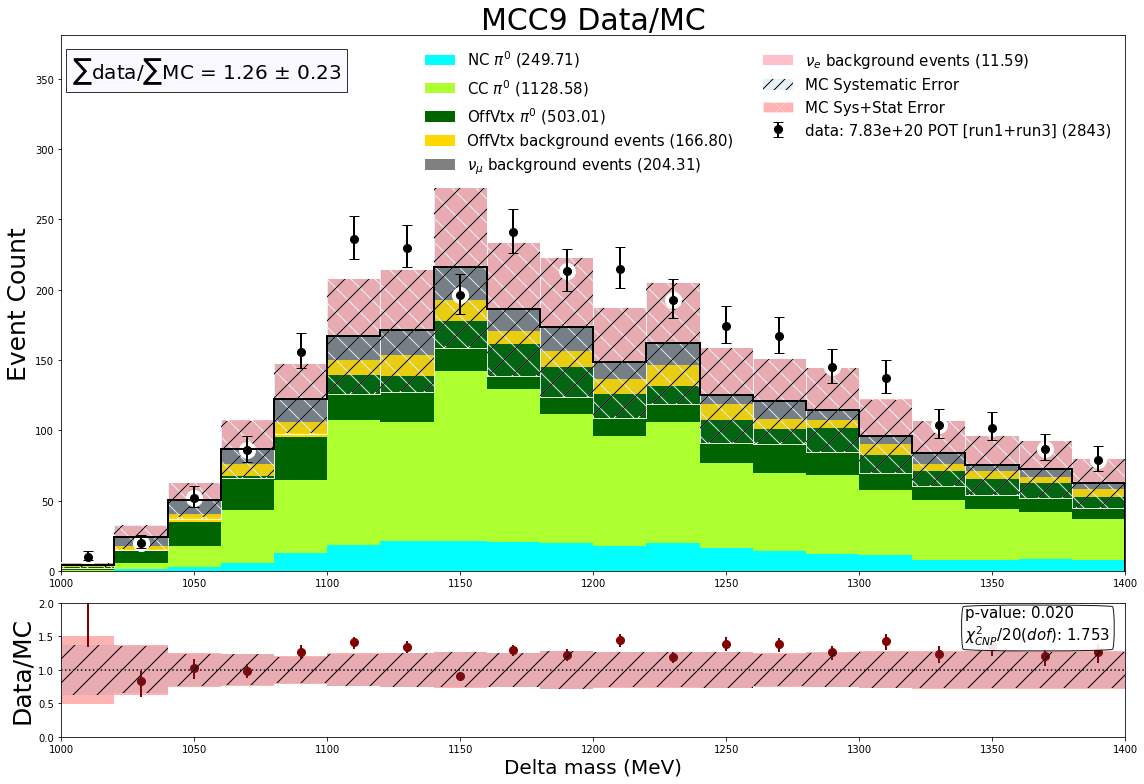

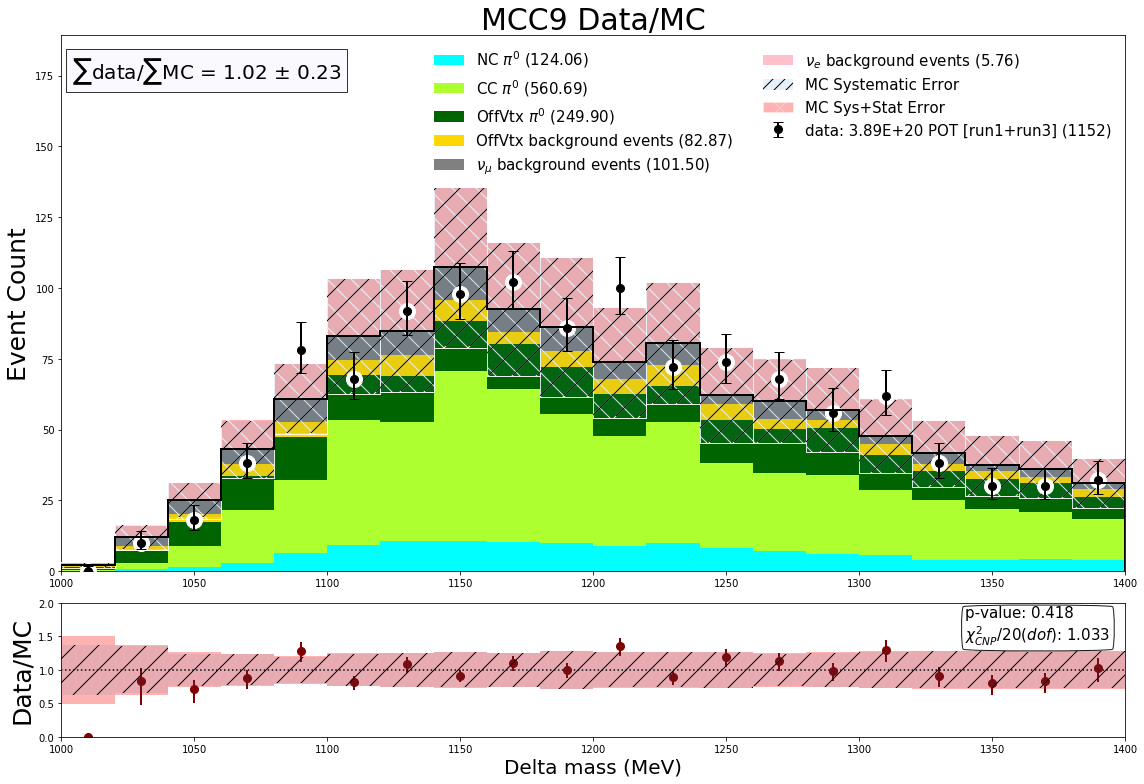

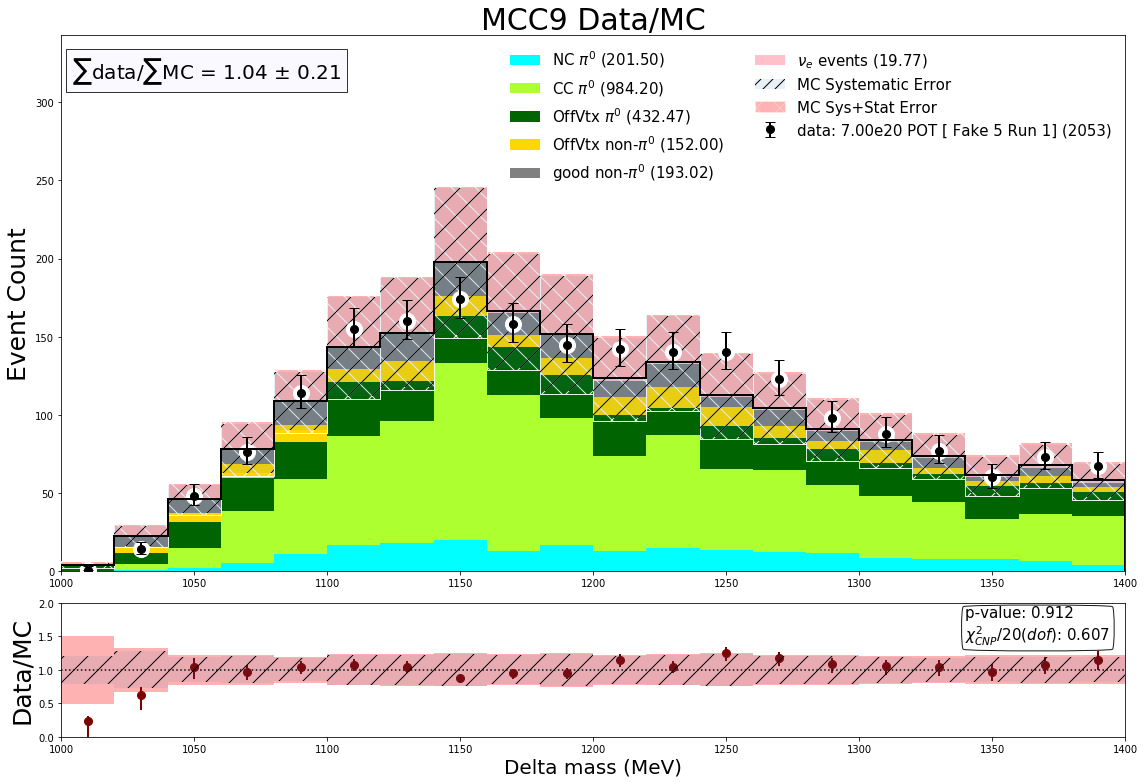

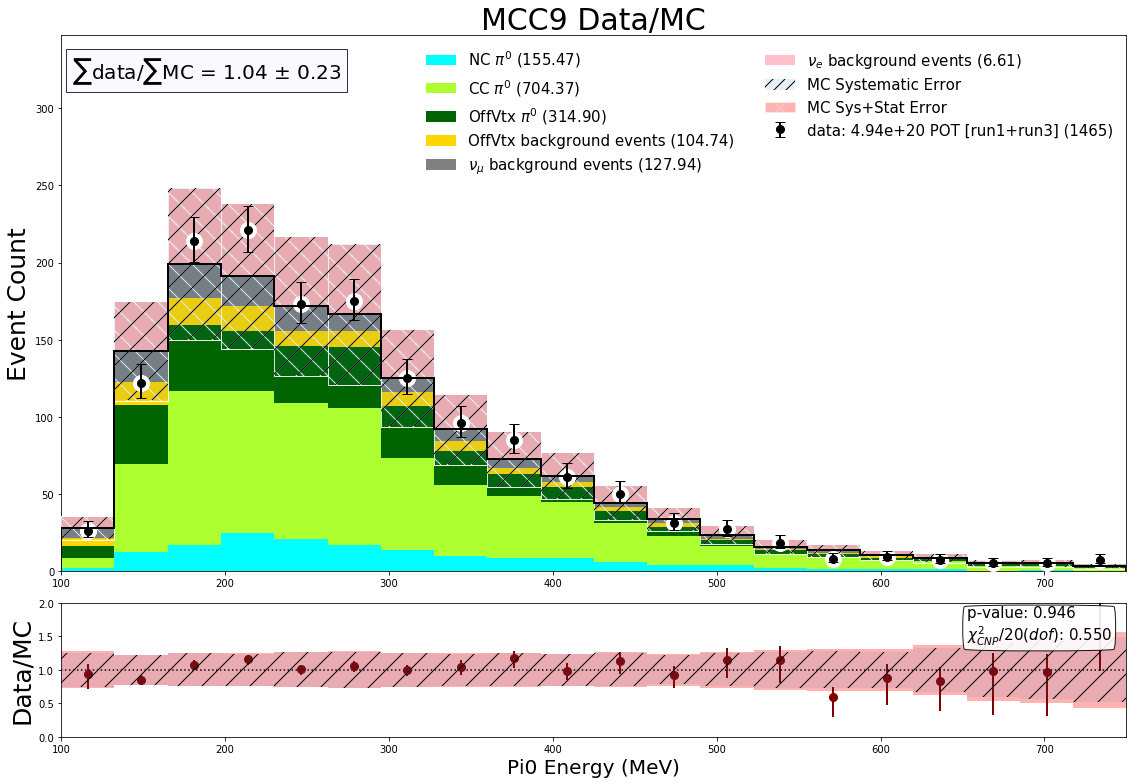

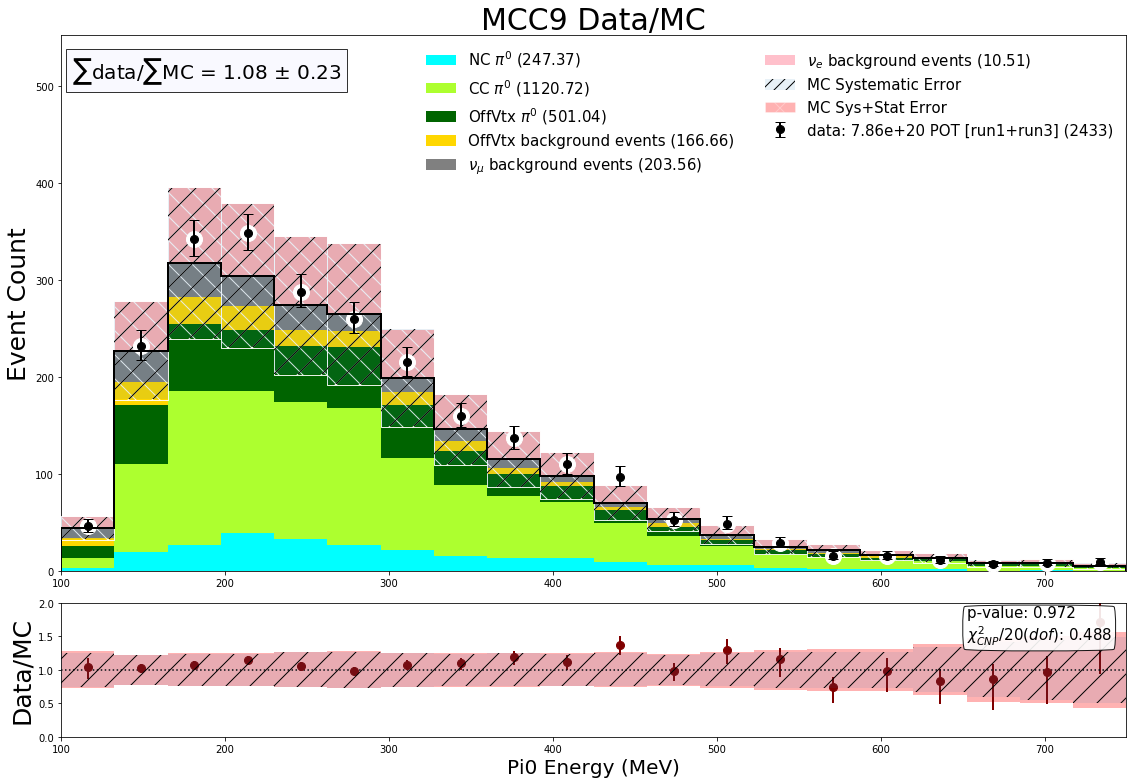

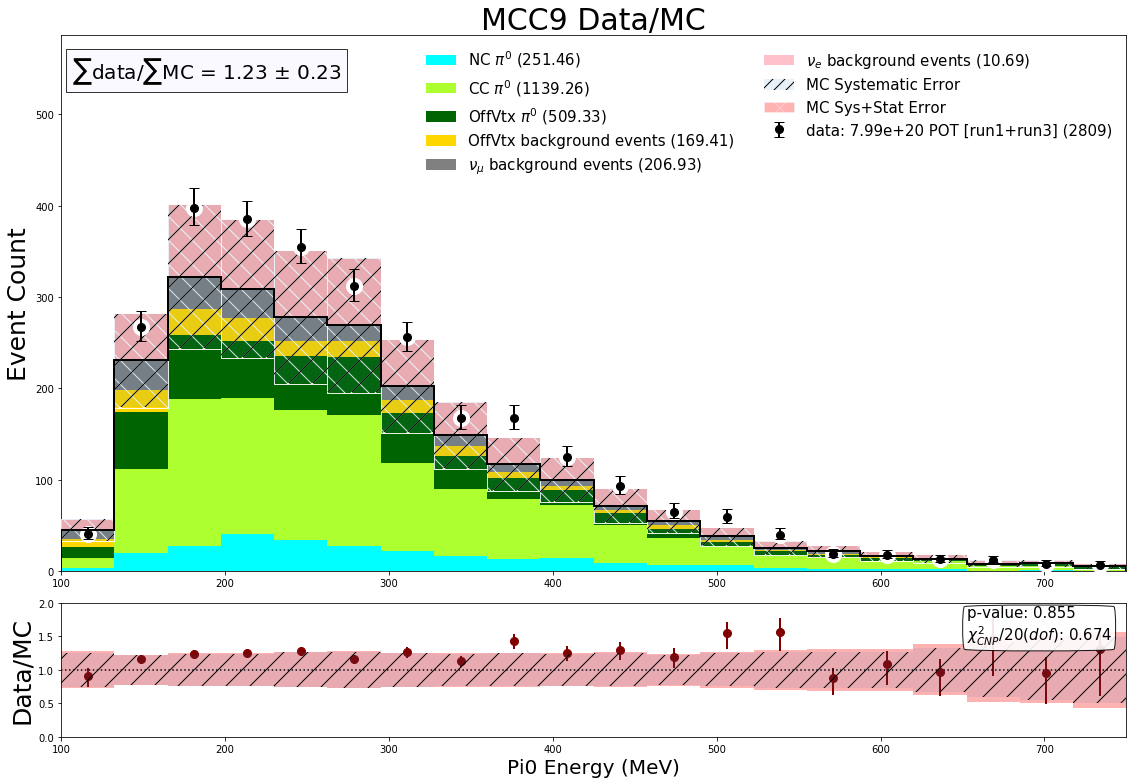

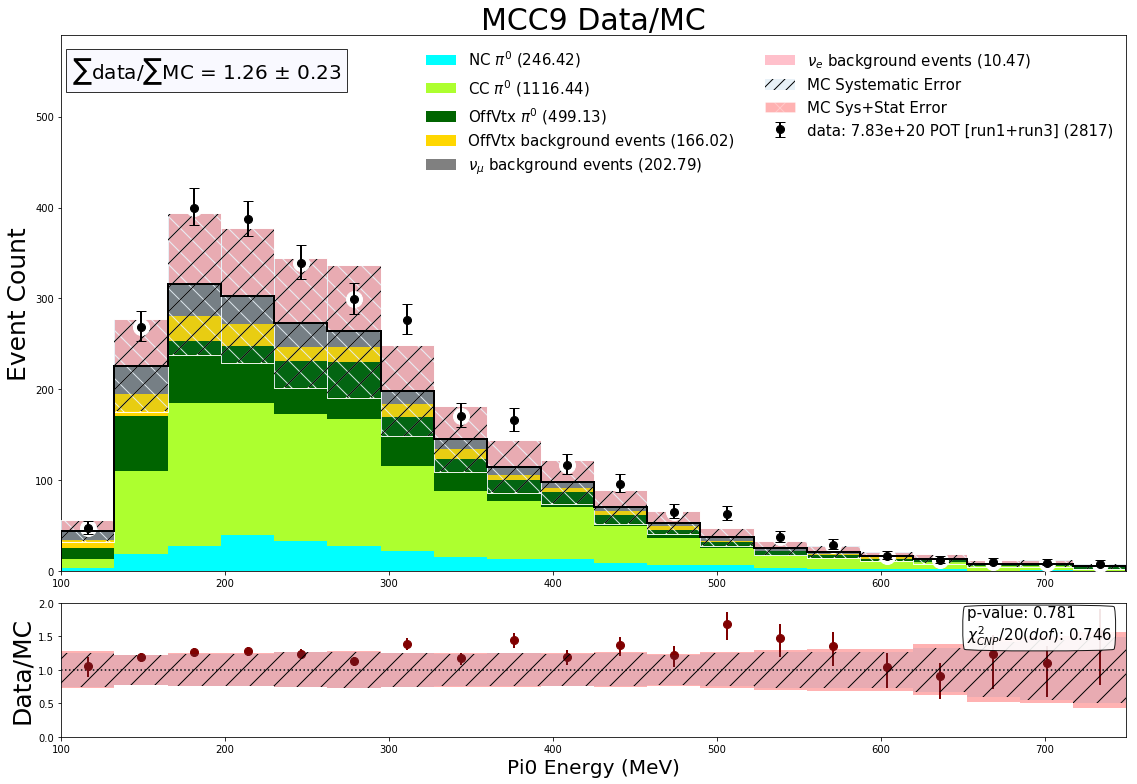

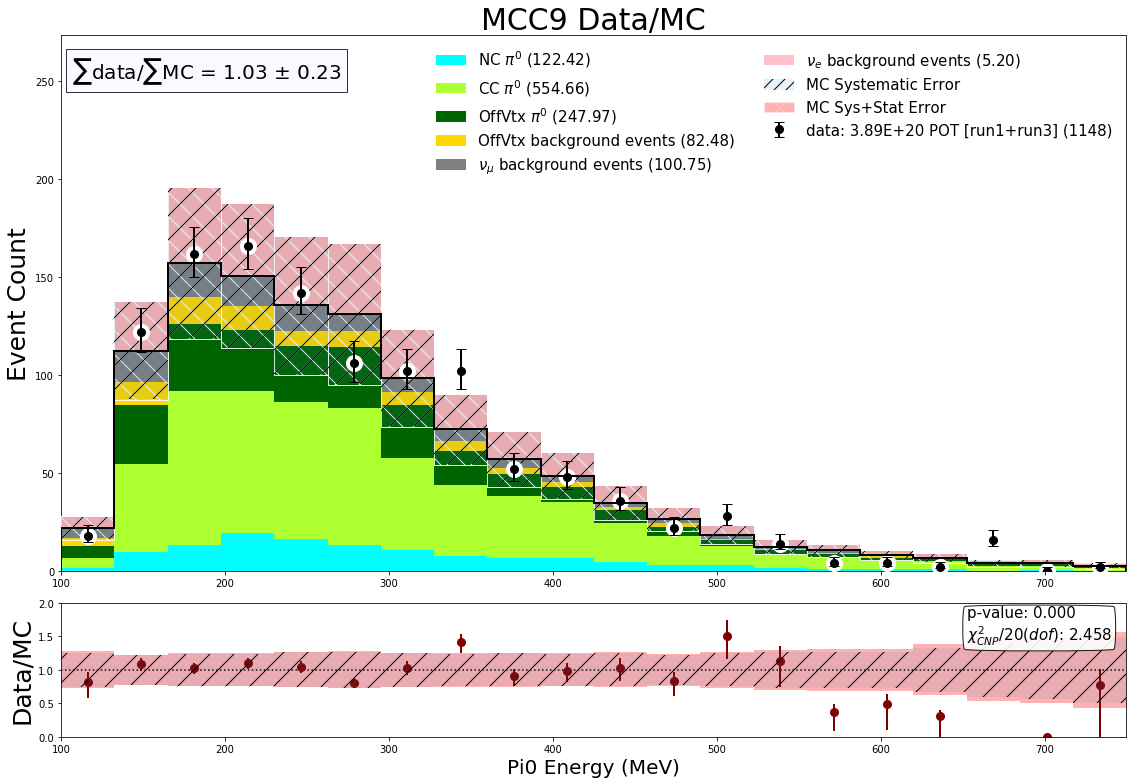

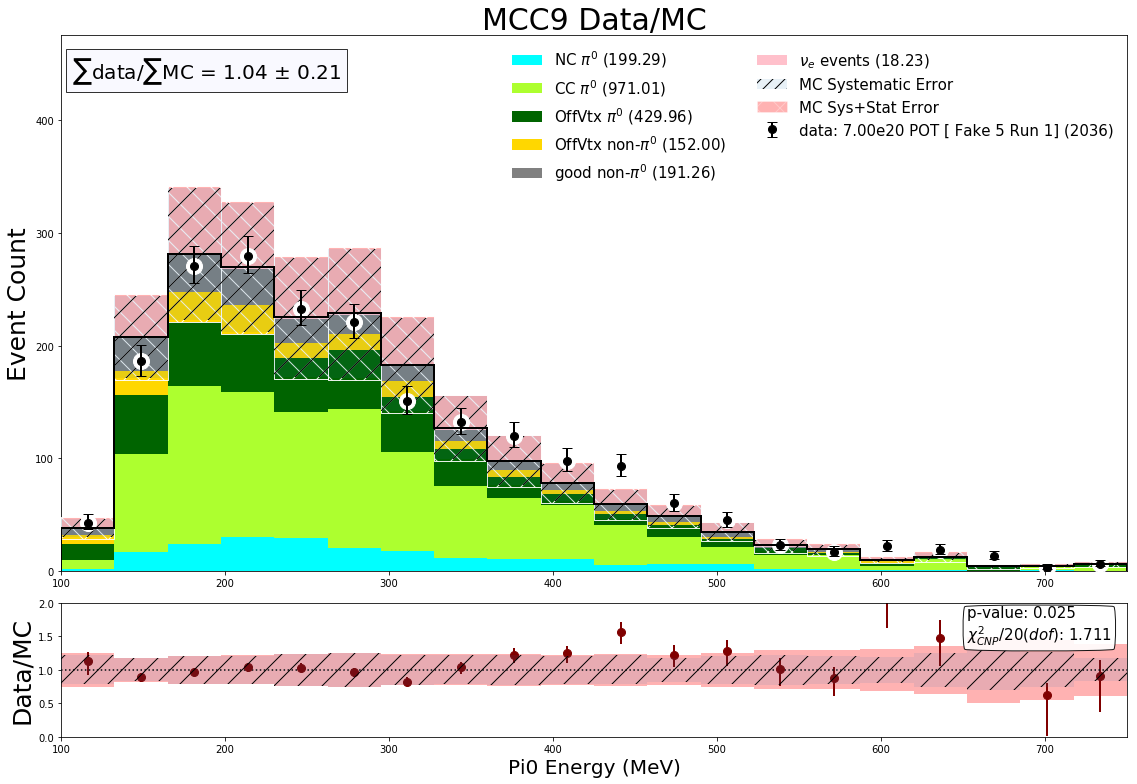

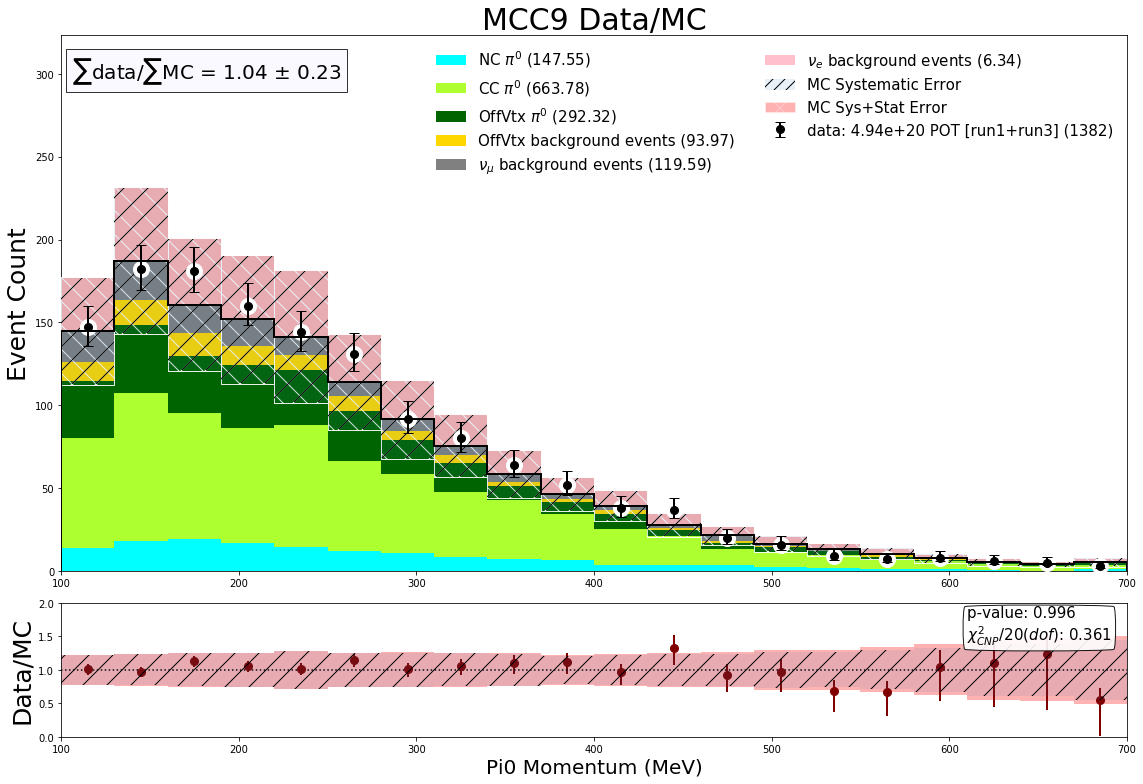

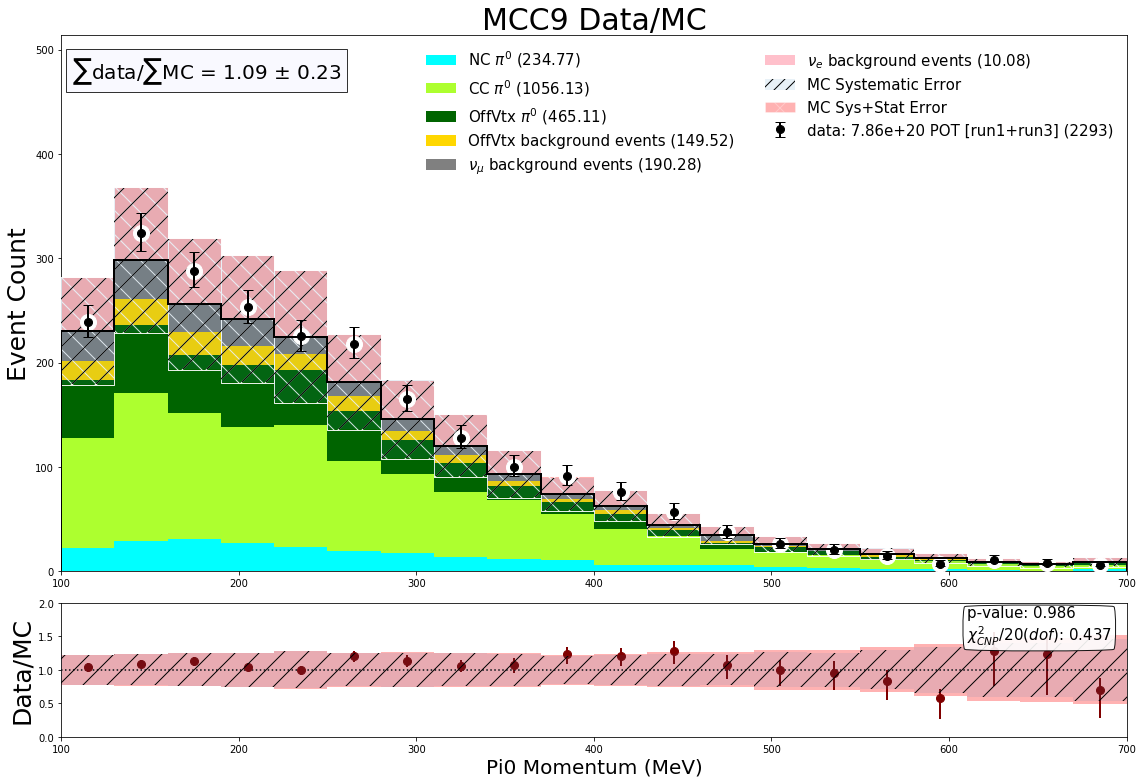

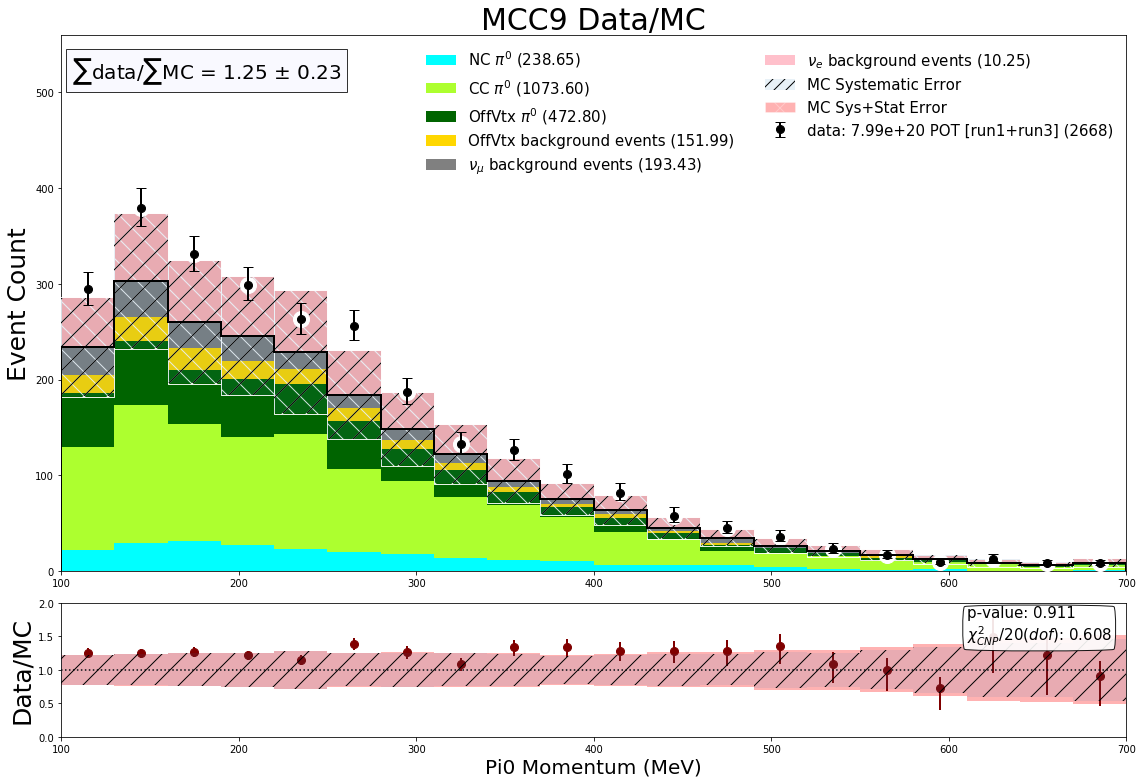

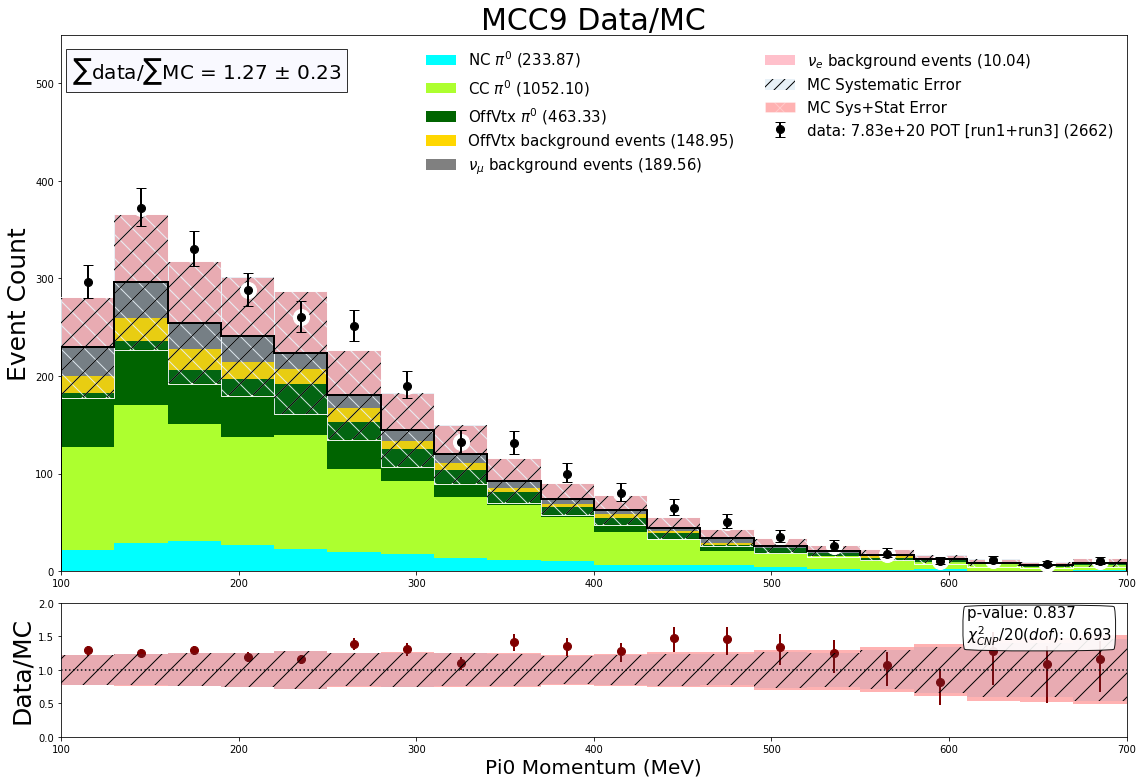

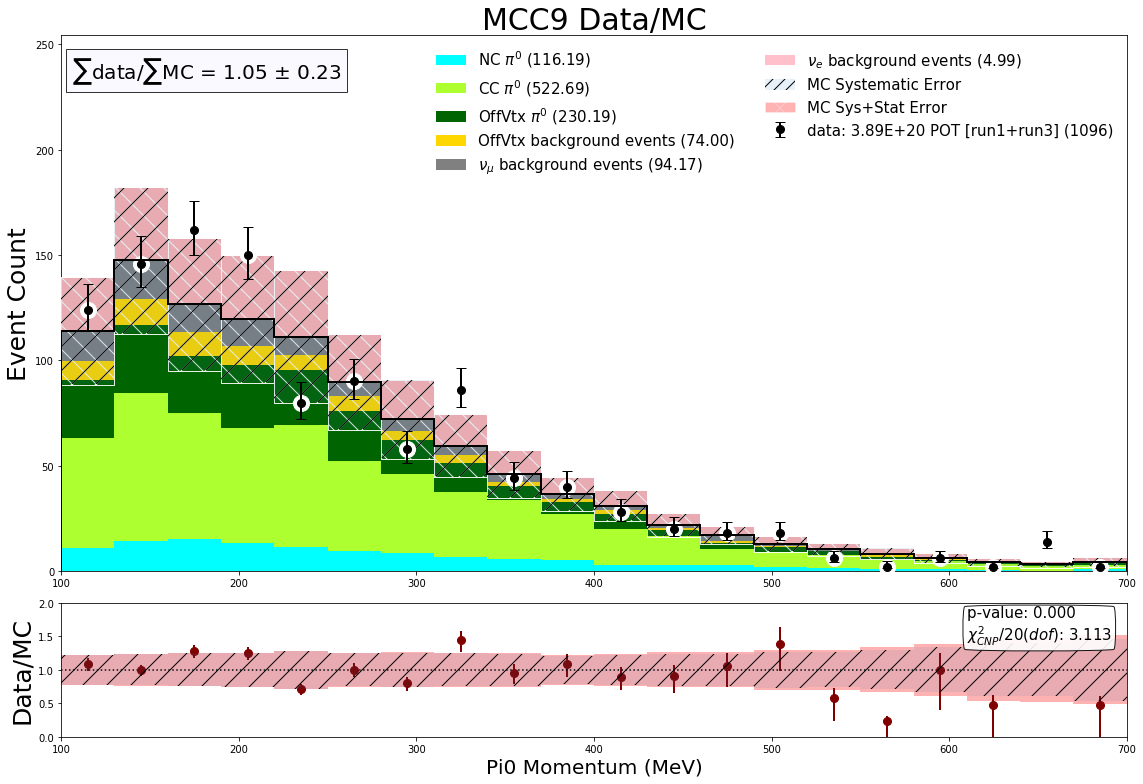

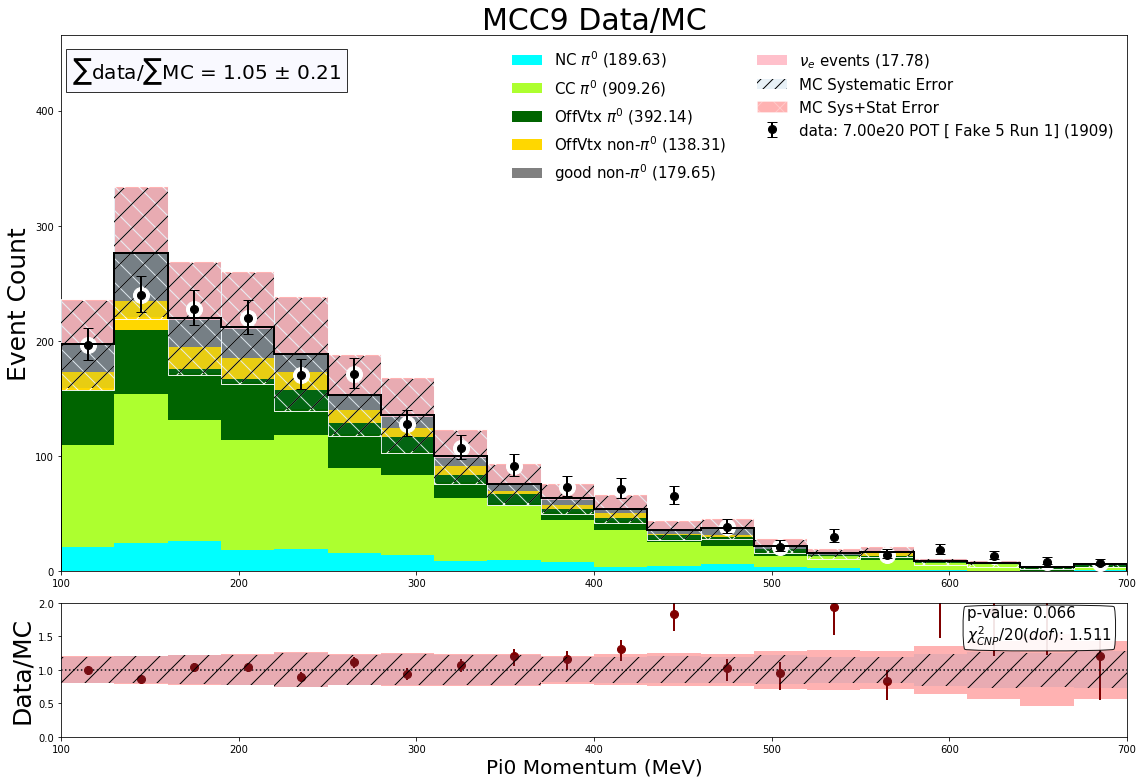

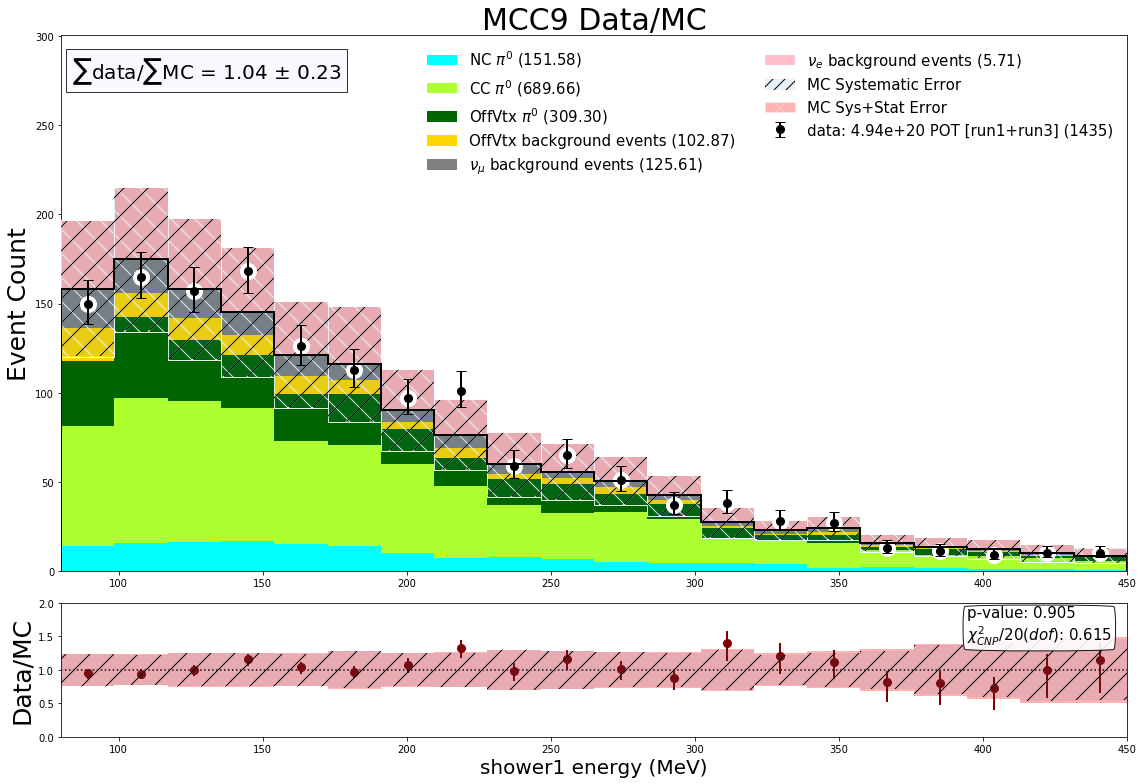

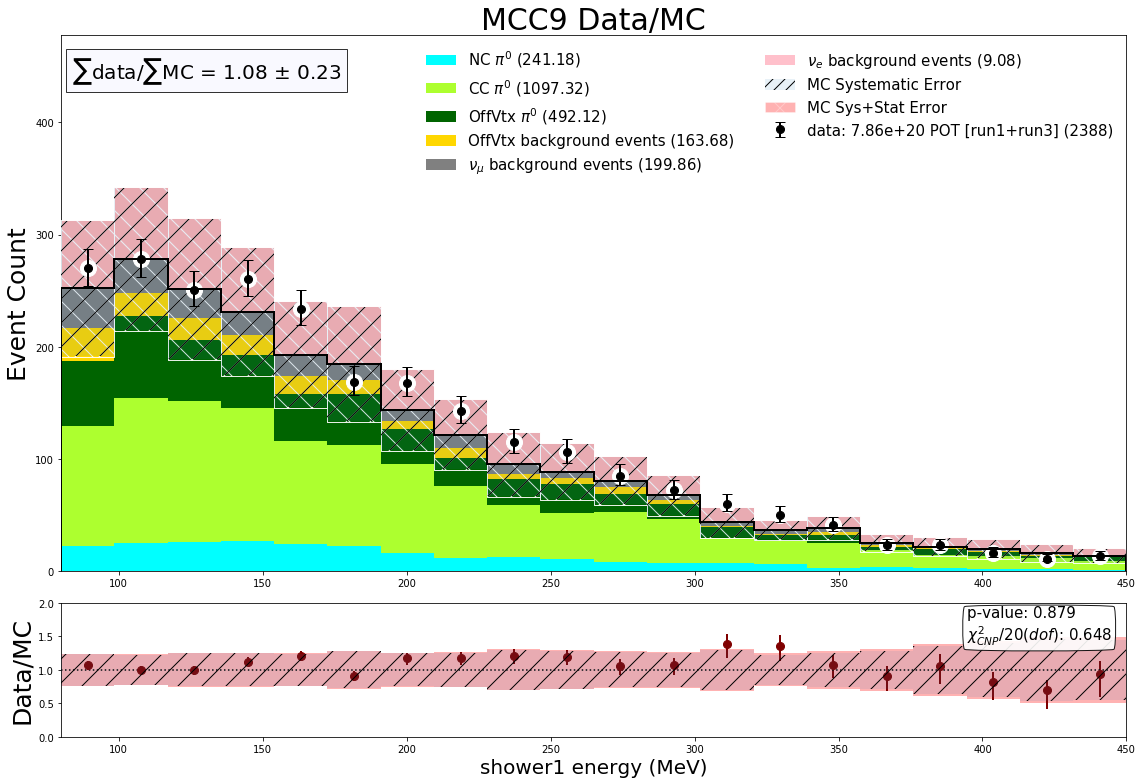

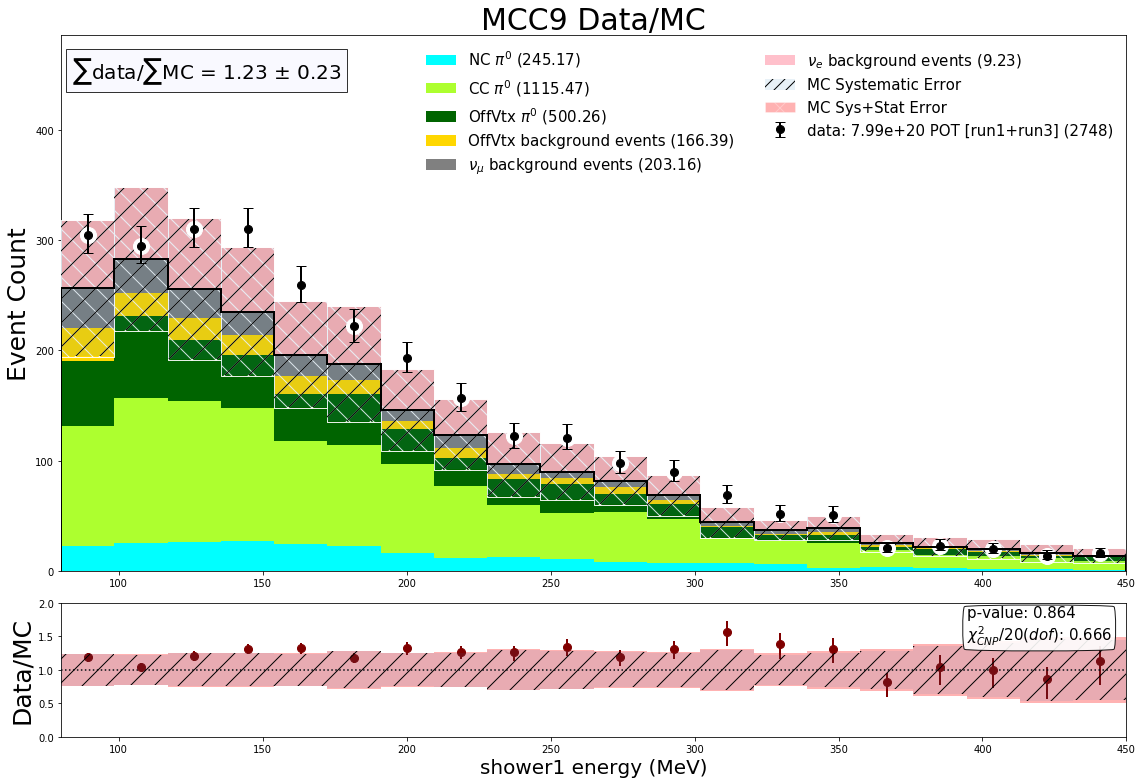

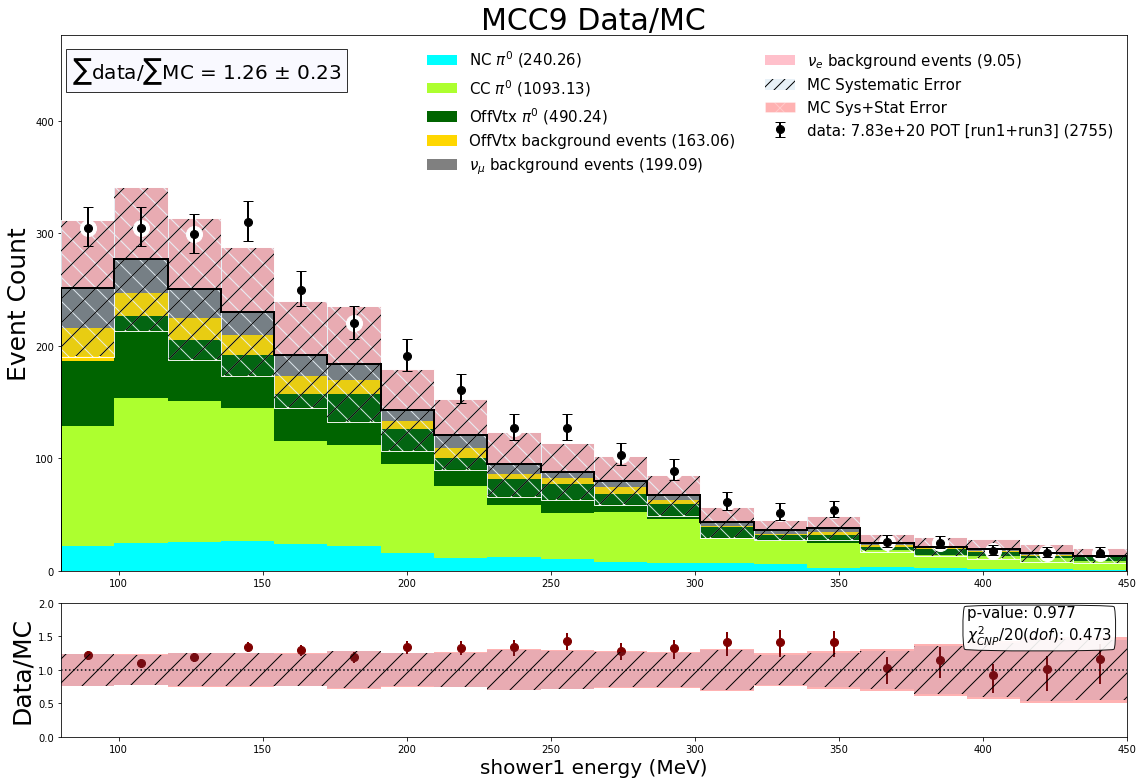

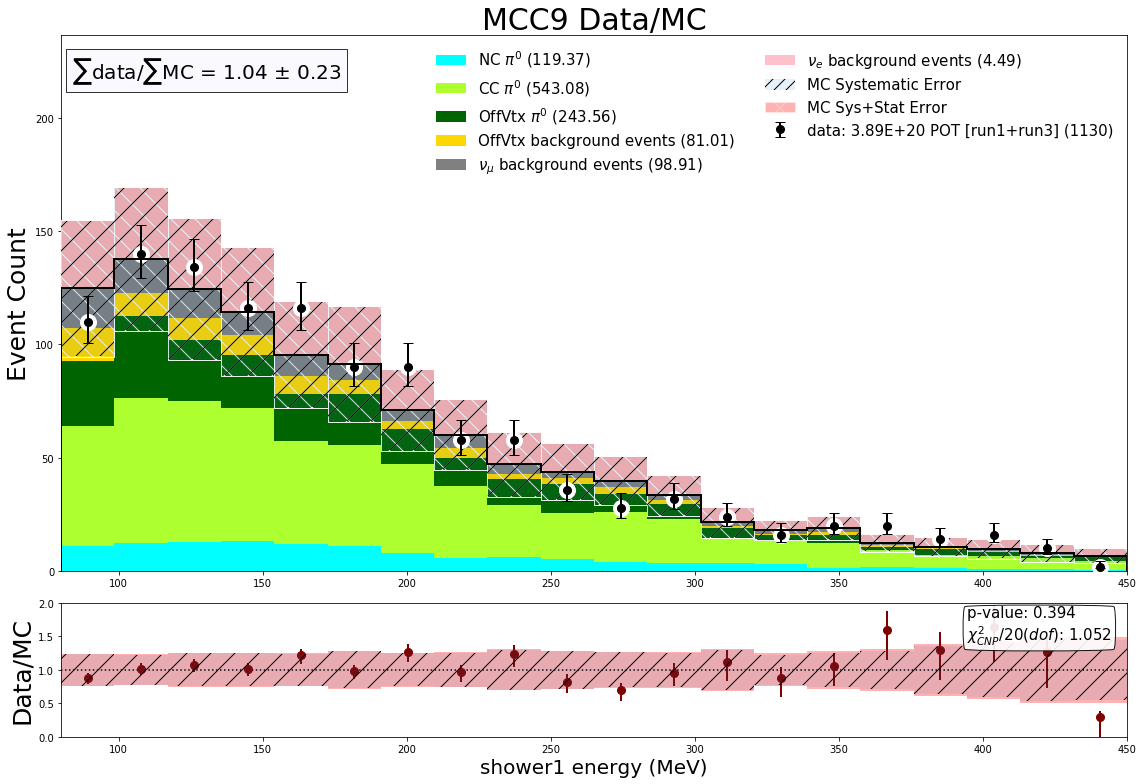

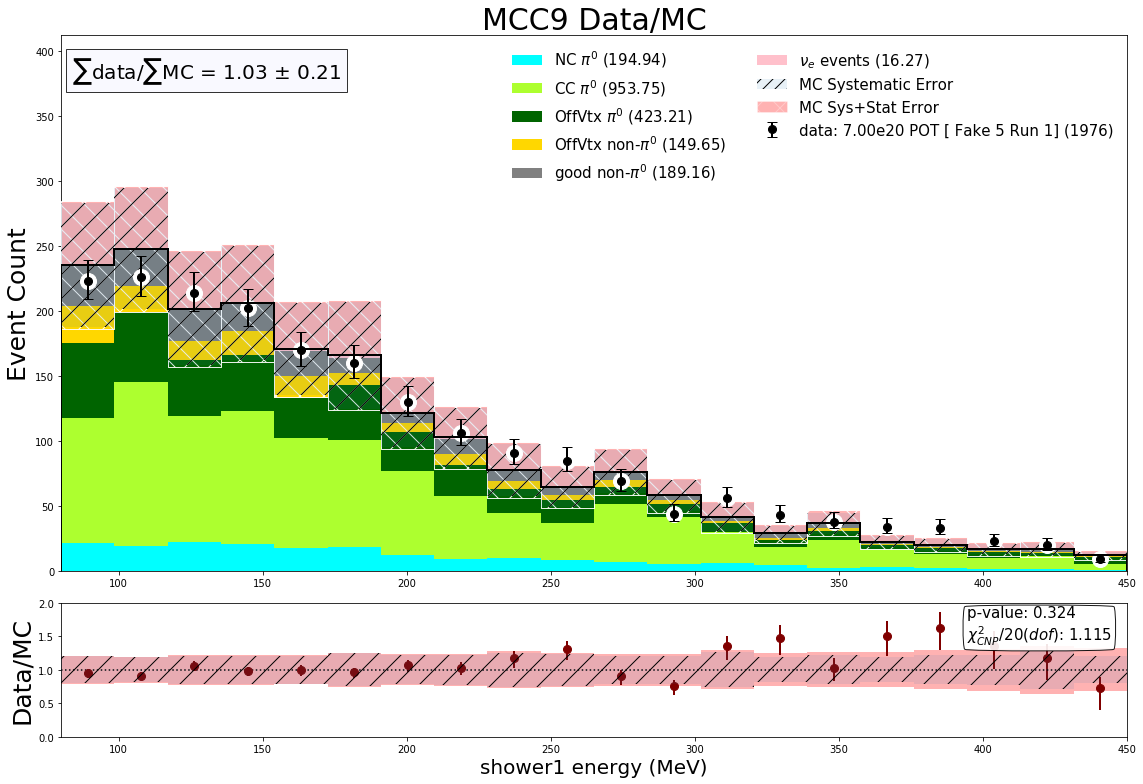

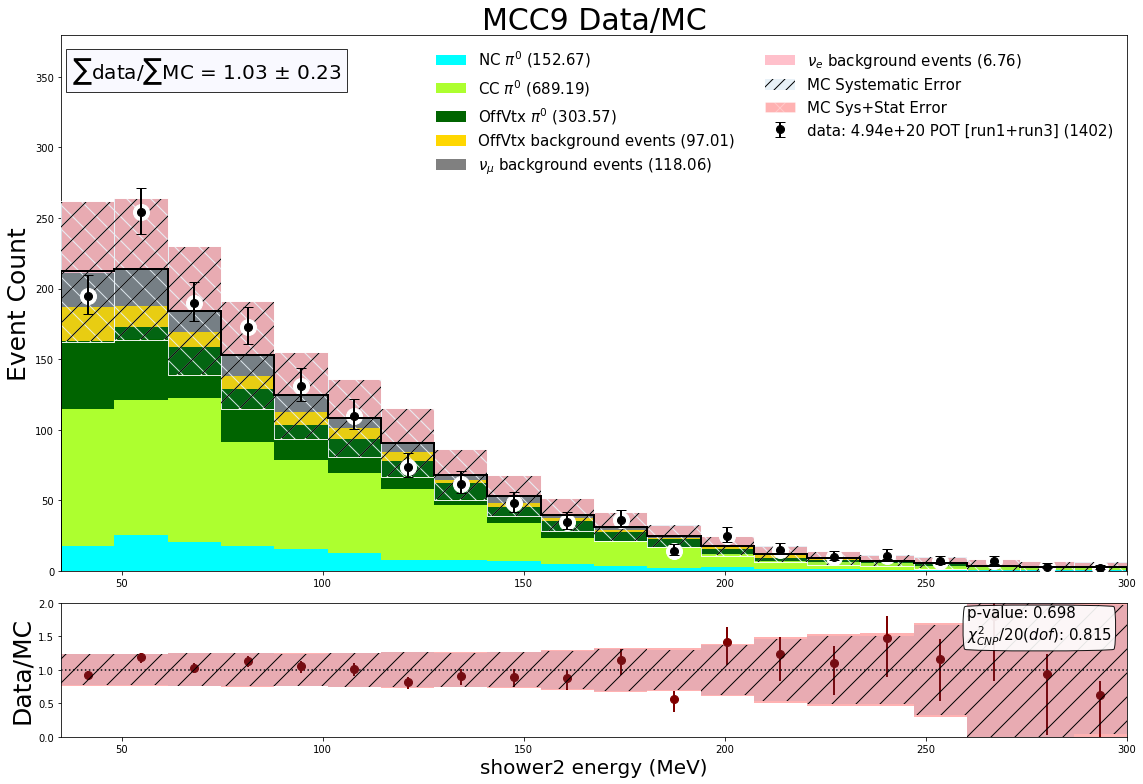

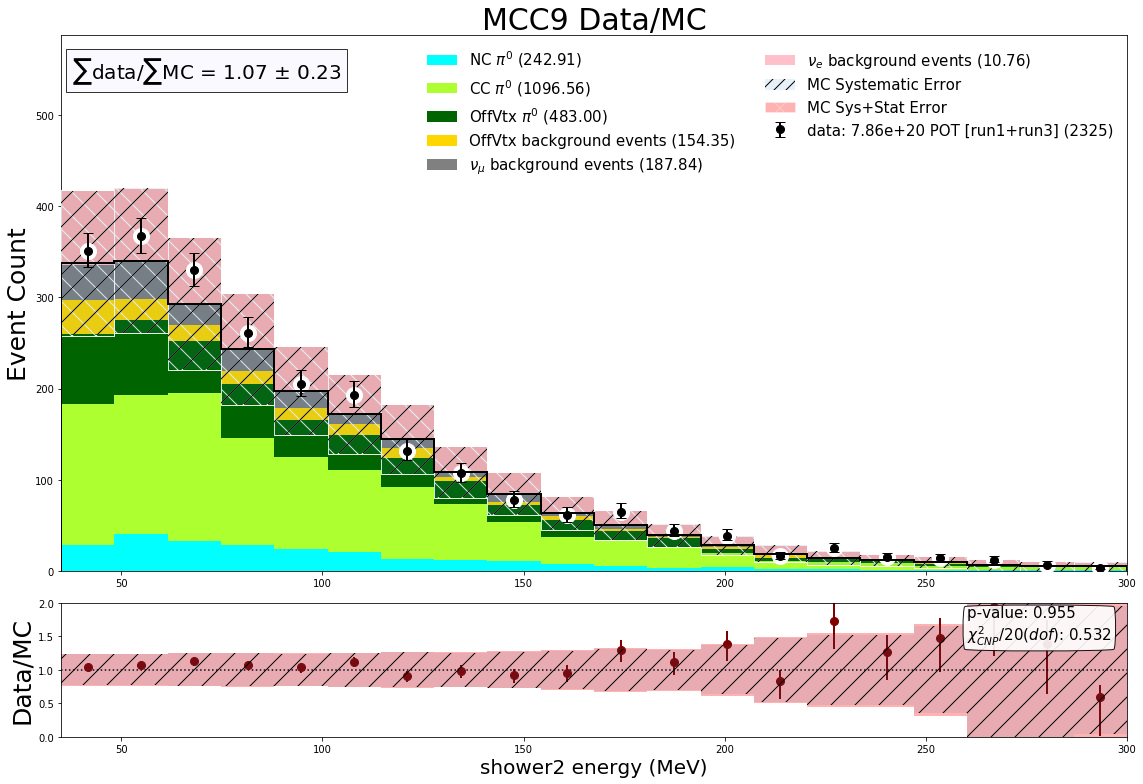

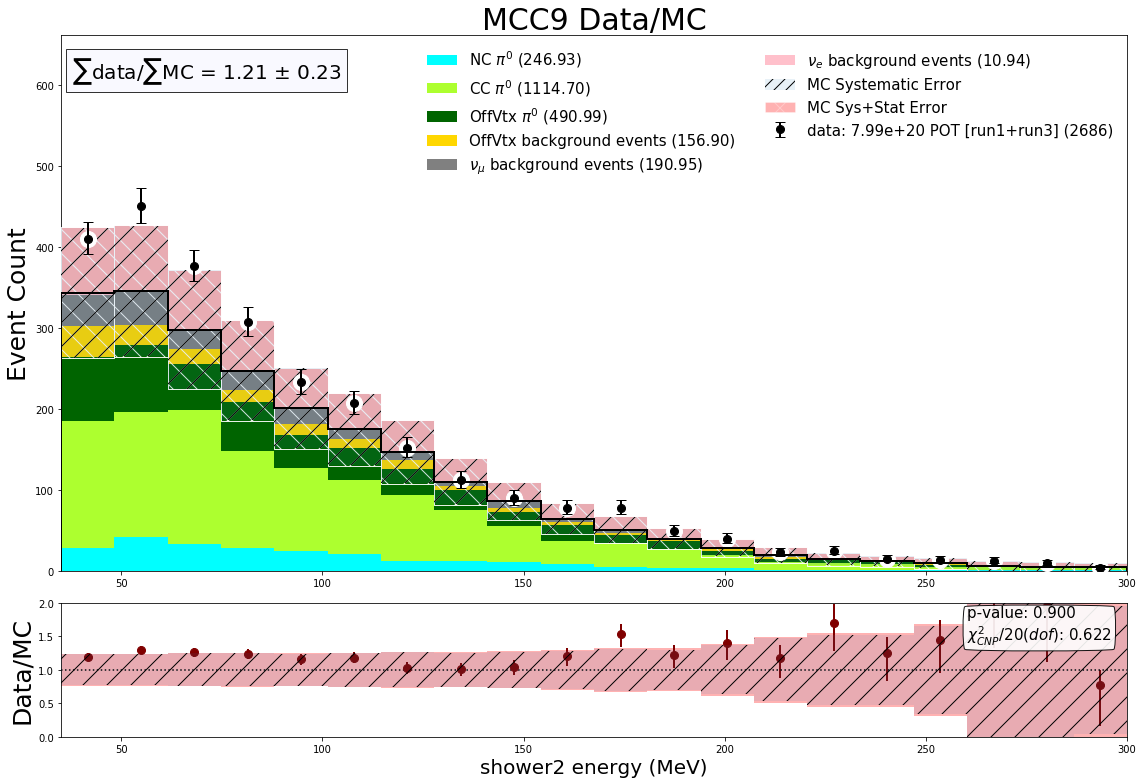

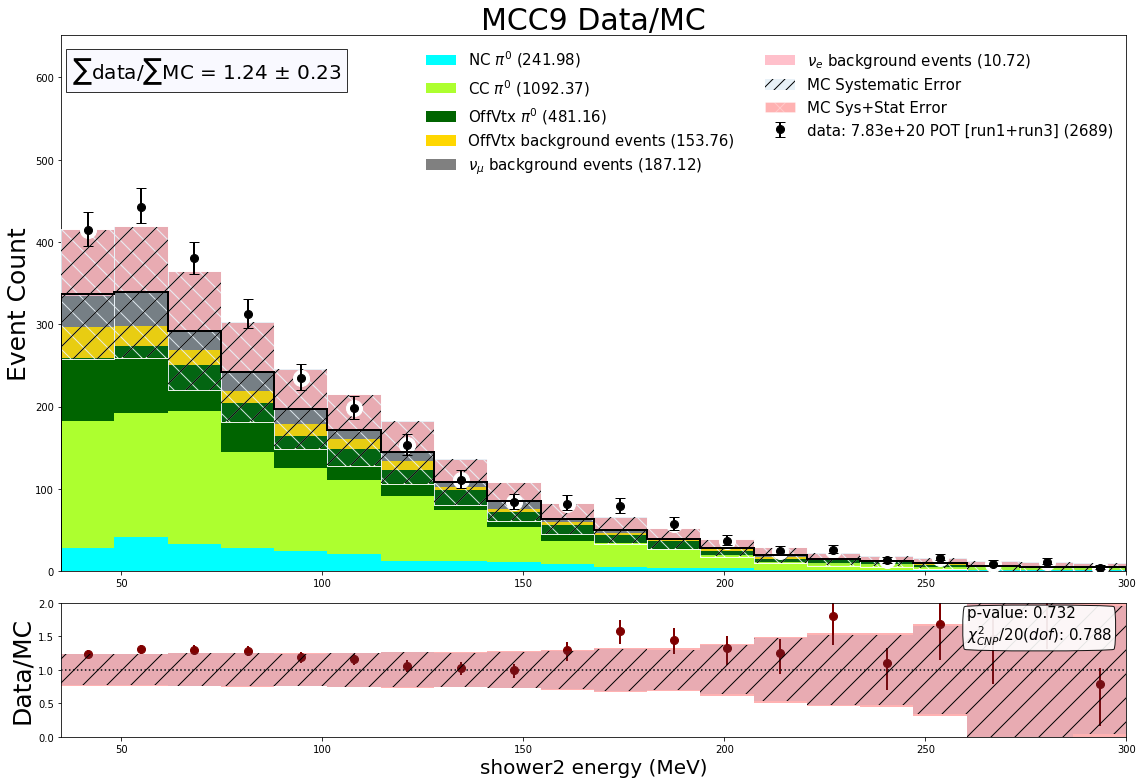

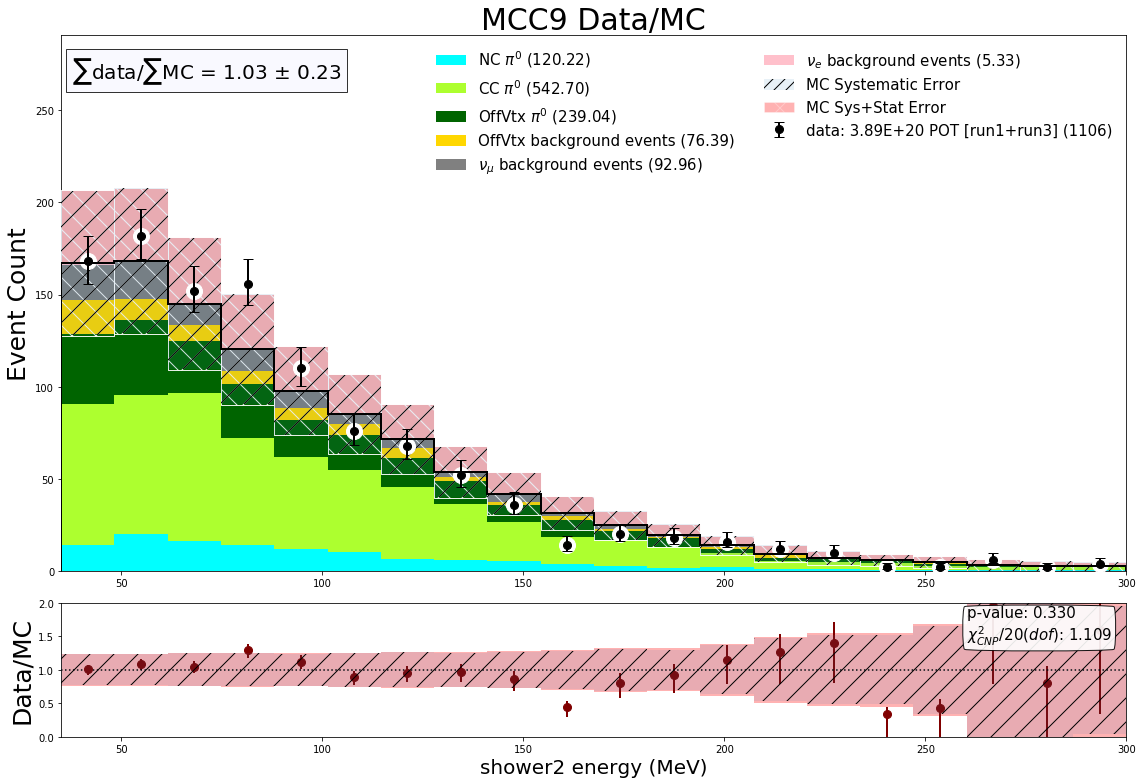

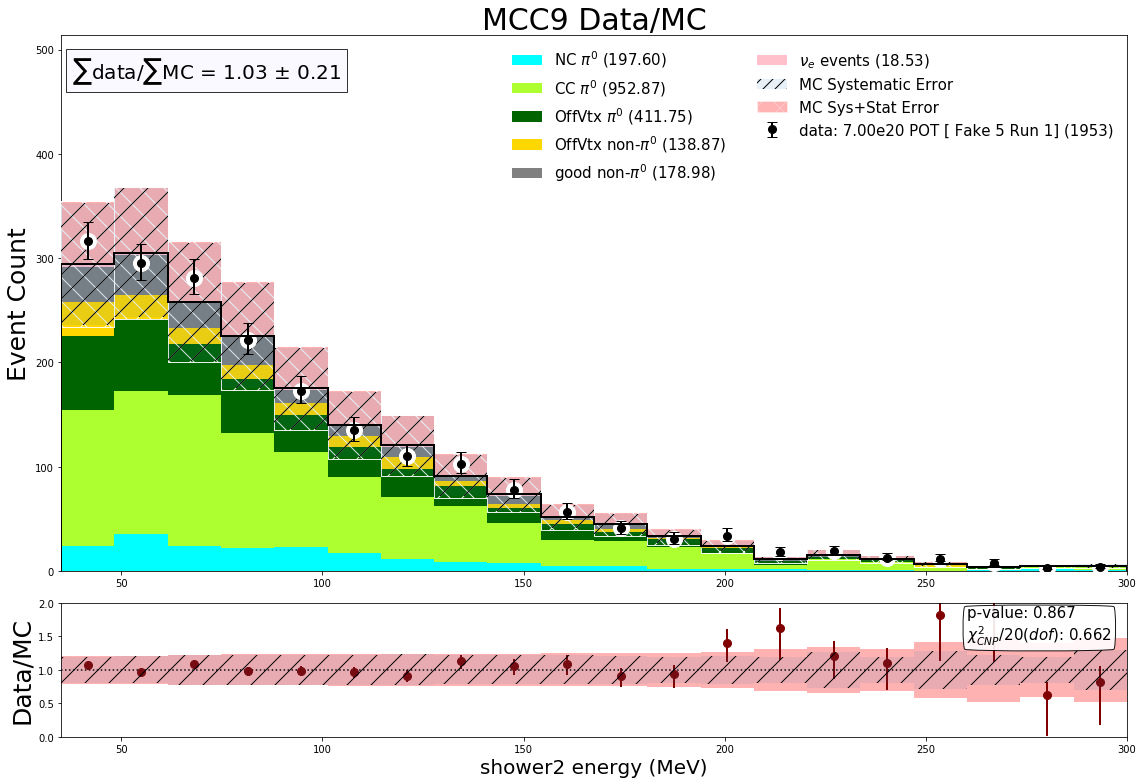

In [15]:
norm = 1.0

for i in range(len(vartest_list)):
    vartest = vartest_list[i]
    varname = varname_list[i]
    myrange = myrange_list[i]
    nbins =bins_list[i]

    if sys_list[i] == 'none':
        s_cov = np.zeros((nbins,nbins))
    else:
        s_cov = np.genfromtxt(sys_list[i],delimiter=',')
        


    d_cov1 = np.genfromtxt(detvar1_list[i],delimiter=',')
    d_cov3 = np.genfromtxt(detvar3_list[i],delimiter=',')
    d_cov = ((FAKE_DATA_1_RUN1_POT)*d_cov1 + (FAKE_DATA_1_RUN3_POT)*d_cov3)/(DATA_POT_TOTAL_1)
    cov = s_cov +d_cov
    run1_open_Hists = StackedHisto((df_numu_total.query('(newhaspi0==0 and MC_parentPDG ==14) or MC_parentPDG ==-14'),df_nue_total.query('MC_parentPDG ==12'),df_ncpi0_total,df_ccpi0_total),(NUMU_SCALE_TOTAL_1,NUE_SCALE_TOTAL_1,NCPI0_SCALE_TOTAL_1,CCPI0_SCALE_TOTAL_1))
    run1_open_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
    run1_open_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
    run1_open_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
    run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx background events",'gold')
    run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"$\nu_\mu$ background events",'grey')
    run1_open_Hists.AddStrata('MC_parentPDG ==12 and haspi0==0',r"$\nu_e$ background events",'pink')
    run1_open_DataHist = SimpleHisto(df_data_total_1,1.0,0,'','data: 4.94e+20 POT [run1+run3]')
    fig1,ax1,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1_open_Hists,run1_open_DataHist,varname,m_cov=cov)
    fig1.savefig(vartest_list[i]+'_fakedata_set1_total.png')
    
    d_cov1 = np.genfromtxt(detvar1_list[i],delimiter=',')
    d_cov3 = np.genfromtxt(detvar3_list[i],delimiter=',')
    d_cov = ((FAKE_DATA_2_RUN1_POT)*d_cov1 + (FAKE_DATA_2_RUN3_POT)*d_cov3)/(DATA_POT_TOTAL_2)
    cov = s_cov +d_cov
    run1_open_Hists = StackedHisto((df_numu_total.query('(newhaspi0==0 and MC_parentPDG ==14) or MC_parentPDG ==-14'),df_nue_total.query('MC_parentPDG ==12'),df_ncpi0_total,df_ccpi0_total),(NUMU_SCALE_TOTAL_2,NUE_SCALE_TOTAL_2,NCPI0_SCALE_TOTAL_2,CCPI0_SCALE_TOTAL_2))
    run1_open_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
    run1_open_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
    run1_open_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
    run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx background events",'gold')
    run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"$\nu_\mu$ background events",'grey')
    run1_open_Hists.AddStrata('MC_parentPDG ==12 and haspi0==0',r"$\nu_e$ background events",'pink')
    run1_open_DataHist = SimpleHisto(df_data_total_2,1.0,0,'','data: 7.86e+20 POT [run1+run3]')
    fig1,ax1,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1_open_Hists,run1_open_DataHist,varname,m_cov=cov)
    fig1.savefig(vartest_list[i]+'_fakedata_set2_total.png')
    
    d_cov1 = np.genfromtxt(detvar1_list[i],delimiter=',')
    d_cov3 = np.genfromtxt(detvar3_list[i],delimiter=',')
    d_cov = ((FAKE_DATA_3_RUN1_POT)*d_cov1 + (FAKE_DATA_3_RUN3_POT)*d_cov3)/(DATA_POT_TOTAL_3)
    cov = s_cov +d_cov
    run1_open_Hists = StackedHisto((df_numu_total.query('(newhaspi0==0 and MC_parentPDG ==14) or MC_parentPDG ==-14'),df_nue_total.query('MC_parentPDG ==12'),df_ncpi0_total,df_ccpi0_total),(NUMU_SCALE_TOTAL_3,NUE_SCALE_TOTAL_3,NCPI0_SCALE_TOTAL_3,CCPI0_SCALE_TOTAL_3))
    run1_open_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
    run1_open_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
    run1_open_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
    run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx background events",'gold')
    run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"$\nu_\mu$ background events",'grey')
    run1_open_Hists.AddStrata('MC_parentPDG ==12 and haspi0==0',r"$\nu_e$ background events",'pink')
    run1_open_DataHist = SimpleHisto(df_data_total_3,1.0,0,'','data: 7.99e+20 POT [run1+run3]')
    fig1,ax1,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1_open_Hists,run1_open_DataHist,varname,m_cov=cov)
    fig1.savefig(vartest_list[i]+'_fakedata_set3_total.png')
    
    d_cov1 = np.genfromtxt(detvar1_list[i],delimiter=',')
    d_cov3 = np.genfromtxt(detvar3_list[i],delimiter=',')
    d_cov = ((FAKE_DATA_4_RUN1_POT)*d_cov1 + (FAKE_DATA_4_RUN3_POT)*d_cov3)/(DATA_POT_TOTAL_4)
    cov = s_cov +d_cov
    run1_open_Hists = StackedHisto((df_numu_total.query('(newhaspi0==0 and MC_parentPDG ==14) or MC_parentPDG ==-14'),df_nue_total.query('MC_parentPDG ==12'),df_ncpi0_total,df_ccpi0_total),(NUMU_SCALE_TOTAL_4,NUE_SCALE_TOTAL_4,NCPI0_SCALE_TOTAL_4,CCPI0_SCALE_TOTAL_4))
    run1_open_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
    run1_open_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
    run1_open_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
    run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx background events",'gold')
    run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"$\nu_\mu$ background events",'grey')
    run1_open_Hists.AddStrata('MC_parentPDG ==12 and haspi0==0',r"$\nu_e$ background events",'pink')
    run1_open_DataHist = SimpleHisto(df_data_total_4,1.0,0,'','data: 7.83e+20 POT [run1+run3]')
    fig1,ax1,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1_open_Hists,run1_open_DataHist,varname,m_cov=cov)
    fig1.savefig(vartest_list[i]+'_fakedata_set4_total.png')
    
    d_cov1 = np.genfromtxt(detvar1_list[i],delimiter=',')
    d_cov3 = np.genfromtxt(detvar3_list[i],delimiter=',')
    d_cov = ((FAKE_DATA_7_RUN1_POT)*d_cov1 + (FAKE_DATA_7_RUN3_POT)*d_cov3)/(DATA_POT_TOTAL_7)
    cov = s_cov +d_cov
    run1_open_Hists = StackedHisto((df_numu_total.query('(newhaspi0==0 and MC_parentPDG ==14) or MC_parentPDG ==-14'),df_nue_total.query('MC_parentPDG ==12'),df_ncpi0_total,df_ccpi0_total),(NUMU_SCALE_TOTAL_7,NUE_SCALE_TOTAL_7,NCPI0_SCALE_TOTAL_7,CCPI0_SCALE_TOTAL_7))
    run1_open_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
    run1_open_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
    run1_open_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
    run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx background events",'gold')
    run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"$\nu_\mu$ background events",'grey')
    run1_open_Hists.AddStrata('MC_parentPDG ==12 and haspi0==0',r"$\nu_e$ background events",'pink')
    run1_open_DataHist = SimpleHisto(df_data_total_7,1.0,0,'','data: 3.89E+20 POT [run1+run3]')
    fig1,ax1,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1_open_Hists,run1_open_DataHist,varname,m_cov=cov)
    fig1.savefig(vartest_list[i]+'_fakedata_set7_total.png')
    
 
    d_cov1 = np.genfromtxt(detvar1_list[i],delimiter=',')
    cov = s_cov +d_cov1
    run1_fake5_Hists = StackedHisto((df_numu_pi0.query('newhaspi0==0'),df_nue_pi0,df_ccpi0_r1_pi0,df_ncpi0_r1_pi0),(NUMU_R1_FAKE5_SCALE,NUE_R1_FAKE5_SCALE,CCPI0_R1_FAKE5_SCALE,NCPI0_R1_FAKE5_SCALE))
    run1_fake5_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
    run1_fake5_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
    run1_fake5_Hists.AddStrata('haspi0==1  and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
    run1_fake5_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
    run1_fake5_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
    run1_fake5_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
    run1_fake5_DataHist = SimpleHisto(df_fakedata5_run1_pi0,1.0,0,'','data: 7.00e20 POT [ Fake 5 Run 1]')
    fig1,ax1,_,p = distplot_wratio_davio(vartest,nbins,myrange,run1_fake5_Hists,run1_fake5_DataHist,varname,m_cov = s_cov)
    fig1.savefig(vartest_list[i]+'_fakedata_set5_total.png')
    